In [6]:
import sys
sys.path.append('/home1/dscho/code/projects/manning_replication')
import os
import glob
import pickle
from time import time
from time import strftime
import random
import itertools
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
from collections import OrderedDict
from importlib import reload

import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
import scipy.signal as signal
import statsmodels.api as sm
 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['figure.dpi'] = 150
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.titlesize'] = 'medium'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 0.8 

import mne
from cluster_helper.cluster import cluster_view
from ptsa.data.TimeSeriesX import TimeSeries 
#from ptsa.data.filters import MorletWaveletFilter
#from ptsa.data.filters import ButterworthFilter
#from ptsa.data.filters import MonopolarToBipolarMapper
import manning_utils
import manning_analysis
from eeg_plotting import plot_trace

In [7]:
## Setup project.
dirs, subj_info, config, subj_df, subj_df_file = manning_analysis.setup_session()
data_dir = dirs['data']
figure_dir = dirs['figs']

# Figure out which subjects have dataframes in metadata.
files = glob.glob(os.path.join(data_dir, 'metadata', 'subj_df_*.xlsx'))
subj_df = pd.read_excel(files[0], converters={'chan': str})
for f in files[1:]:
    subj_df = subj_df.append(pd.read_excel(f, converters={'chan': str}))
subj_df = subj_df.loc[subj_df.location!='none']

# Get a dictionary of all channels with 1+ units.
spike_chans = OrderedDict(subj_df.loc[subj_df.n_clusters>0][['subj_sess', 'chan']].groupby('subj_sess').chan.apply(list))

# Get kept channels.
with open(os.path.join(data_dir, 'other', 'keep_chans.pkl'), 'rb') as f:
    keep_chans = pickle.load(f)     
sessions = sorted(keep_chans.keys())
print('{} sessions'.format(len(sessions)))

Loading subjects DataFrame: /data3/scratch/dscho/frLfp/data/subj_df.xlsx

There are 20 subjects, 46 sessions, and 2944 channels in the study.

46 sessions will be processed: ['U367_env2', 'U369_env1', 'U369_env2', 'U370_env1', 'U371_env1', 'U371_env2', 'U371_env3', 'U372_ses1', 'U372_ses2', 'U373_ses1', 'U373_ses2', 'U373_ses3', 'U374_ses1', 'U374_ses2', 'U379_ses1', 'U380_ses1a', 'U380_ses2', 'U380_ses3', 'U381_ses1', 'U381_ses2', 'U381_ses3', 'U384_ses1', 'U384_ses2', 'U384_ses3', 'U385_ses1', 'U385_ses2', 'U385_ses3', 'U385_ses4', 'U386_ses1', 'U386_ses2', 'U387_ses1', 'U387_ses2', 'U387_ses3', 'U390_ses1', 'U390_ses2', 'U390_ses3', 'U390_ses4', 'U392_ses1', 'U393_ses2', 'U394_ses1', 'U394_ses3', 'U395_ses1', 'U395_ses2', 'U395_ses3', 'U396_ses2', 'U396_ses3']
0 sessions have missing input files and will not be processed.

46 sessions


In [271]:
with open(os.path.join(data_dir, 'virtual_lfp', 'epoch', 'powfr_betas2_{}Hz.pkl'.format(epoch_rate)), 'rb') as f:
    powfr_betas2 = pickle.load(f)
    
with open(os.path.join(data_dir, 'virtual_lfp', 'epoch', 'powfr_betas2_rand_{}Hz.pkl'.format(epoch_rate)), 'rb') as f:
    powfr_betas2_rand = pickle.load(f)
    
with open(os.path.join(data_dir, 'virtual_lfp', 'epoch', 'powfr_betas3_{}Hz.pkl'.format(epoch_rate)), 'rb') as f:
    powfr_betas3 = pickle.load(f)
    
with open(os.path.join(data_dir, 'virtual_lfp', 'epoch', 'powfr_betas3_rand_{}Hz.pkl'.format(epoch_rate)), 'rb') as f:
    powfr_betas3_rand = pickle.load(f)

with open(os.path.join(data_dir, 'virtual_lfp', 'epoch', 'epoch_power_freqs_log_Z-acrossfreq_{}Hz.pkl'.format(epoch_rate)), 'rb') as f:
    epoch_power_freqs_za = pickle.load(f)
    
with open(os.path.join(data_dir, 'virtual_lfp', 'epoch', 'epoch_power_freqs_log_Z-withinfreq_{}Hz.pkl'.format(epoch_rate)), 'rb') as f:
    epoch_power_freqs_zw = pickle.load(f)

In [13]:
# Load saved data.
epoch_rate = 2

with open(os.path.join(data_dir, 'virtual_lfp', 'epoch', 'epoch_fr_{}Hz.pkl'.format(epoch_rate)), 'rb') as f:
    epoch_fr = pickle.load(f)

with open(os.path.join(data_dir, 'virtual_lfp', 'epoch', 'epoch_power_{}Hz.pkl'.format(epoch_rate)), 'rb') as f:
    epoch_power = pickle.load(f)
    
powfr_corr_df = pd.read_excel(os.path.join(data_dir, 'virtual_lfp', 'epoch', 'powfr_corr_df_{}Hz.xlsx'.format(epoch_rate)))
powfr_ols2_df = pd.read_excel(os.path.join(data_dir, 'virtual_lfp', 'epoch', 'powfr_ols2_df_{}Hz.xlsx'.format(epoch_rate)))
powfr_ols3_df = pd.read_excel(os.path.join(data_dir, 'virtual_lfp', 'epoch', 'powfr_ols3_df_{}Hz.xlsx'.format(epoch_rate)))

nbands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
power_measures = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'tilt', 'bband_power']

## Ideas

In [ ]:
# For each ROI, sort epochs by firing rate and divide into 50 bins.
# Within each bin, take the average Z-scored log-power value at each frequency.
# Could plot this average power as a heat map (firing rate bin x frequency) 
# at the single-region level, or could average across all regions and plot that.
# Also, might be interesting to do this on re-sorted epochs after regressing broadband
# power or tilt out of the firing rate vector.

# Scatterplot (or firing rate x broadband power, across all regions. Could try
# playing around with adding tilt as color or something to look at visual group effects.
# Or...
# Using the same 50 firing rate bins as above, calculate mean firing rate and
# mean broadband power within each bin, for each region. Plot mean +/- SEM of
# firing rate x broadband power across regions. Could do the same for tilt. 

# Make plots of pct positive/negative correlations of power measures w/ firing 
# rate, for Pearson, bivariate, and trivariate reg models

# Run regressions of just tilt + broadband power? 

# Correlate LFP traces to each other and power at each frequency among LFP traces 
# to each other (both across time)

# Create a plot showing log-power at each frequency going into the robust regression
# model, along with estimates of broadband power, tilt, and power at each band

## Plot firing rate properties

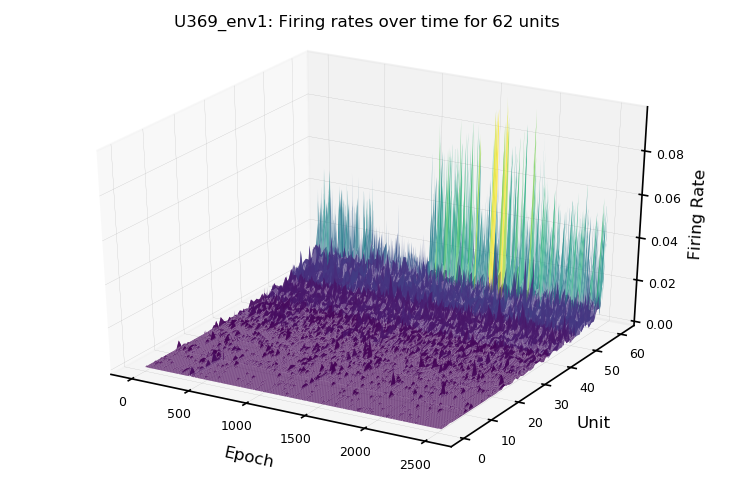

In [595]:
# Plot the mean firing rate for each cluster in the session, over epoch and time. 
subj_sess = 'U369_env1'

with open(os.path.join(data_dir, 'spikes', '{}_session_spikes.pkl'.format(subj_sess)), 'rb') as f:
    spikes = pickle.load(f)
fr_df, clus_to_chan, chan_to_clus = manning_analysis.get_fr_df(subj_sess, spikes)
n_timepoints = len(fr_df.fr.iat[0])
sampling_rate = 2000.
time_bins = manning_utils.get_epochs(np.arange(n_timepoints), epoch_size=(sampling_rate/epoch_rate))
fr = np.array(fr_df.fr.tolist()) # cluster x time

epoch_fr_roi = []
for start, stop in time_bins:
    epoch_fr_roi.append(np.mean(fr[:, start:stop], axis=1))
epoch_fr_roi = np.array(epoch_fr_roi).T # cluster x epoch
clus_sort = np.argsort(np.mean(epoch_fr_roi, axis=1))
epoch_sort = np.argsort(np.median(epoch_fr_roi, axis=0))

plt.close('all')
fig = plt.figure(dpi=150)
ax = fig.gca(projection='3d')

dat = epoch_fr_roi[clus_sort, :]#[:, epoch_sort]

x = np.repeat(np.arange(dat.shape[0]), dat.shape[1])
y = np.tile(np.arange(dat.shape[1]), dat.shape[0])
z = dat.flatten()

x, y = np.meshgrid(np.arange(dat.shape[1]), np.arange(dat.shape[0]))
ax.plot_surface(x, y, dat, cmap='viridis', alpha=0.75, rstride=10, cstride=10)
for item in ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels():
    item.set_fontsize(6)
ax.tick_params(pad=-1)
ax.set_xlabel('Epoch', fontsize=8, labelpad=-1)
ax.set_ylabel('Unit', fontsize=8, labelpad=-1)
ax.set_zlabel('Firing Rate', fontsize=8, labelpad=-5)
ax.set_title('{}: Firing rates over time for {} units'.format(subj_sess, len(epoch_fr_roi)), 
             fontsize=8, pad=15)

f = os.path.join(figure_dir, '{}_epoch_firing_rates_over_time.png'.format(subj_sess))
#fig.savefig(f)

In [495]:
subj_sess = 'U369_env1'
roi = 'LA'

with open(os.path.join(data_dir, 'spikes', '{}_session_spikes.pkl'.format(subj_sess)), 'rb') as f:
    spikes = pickle.load(f)
fr_df, clus_to_chan, chan_to_clus = manning_analysis.get_fr_df(subj_sess, spikes)
n_timepoints = len(fr_df.fr.iat[0])
sampling_rate = 2000.
fr_roi_df = fr_df.loc[fr_df.location==roi]
fr = np.array(fr_roi_df.fr.tolist()) # cluster x time
fr = fr.T # flip to time x cluster
zfr = (fr - np.mean(fr, axis=0)) / np.std(fr, axis=0)
zfr = zfr.T # back to cluster x time

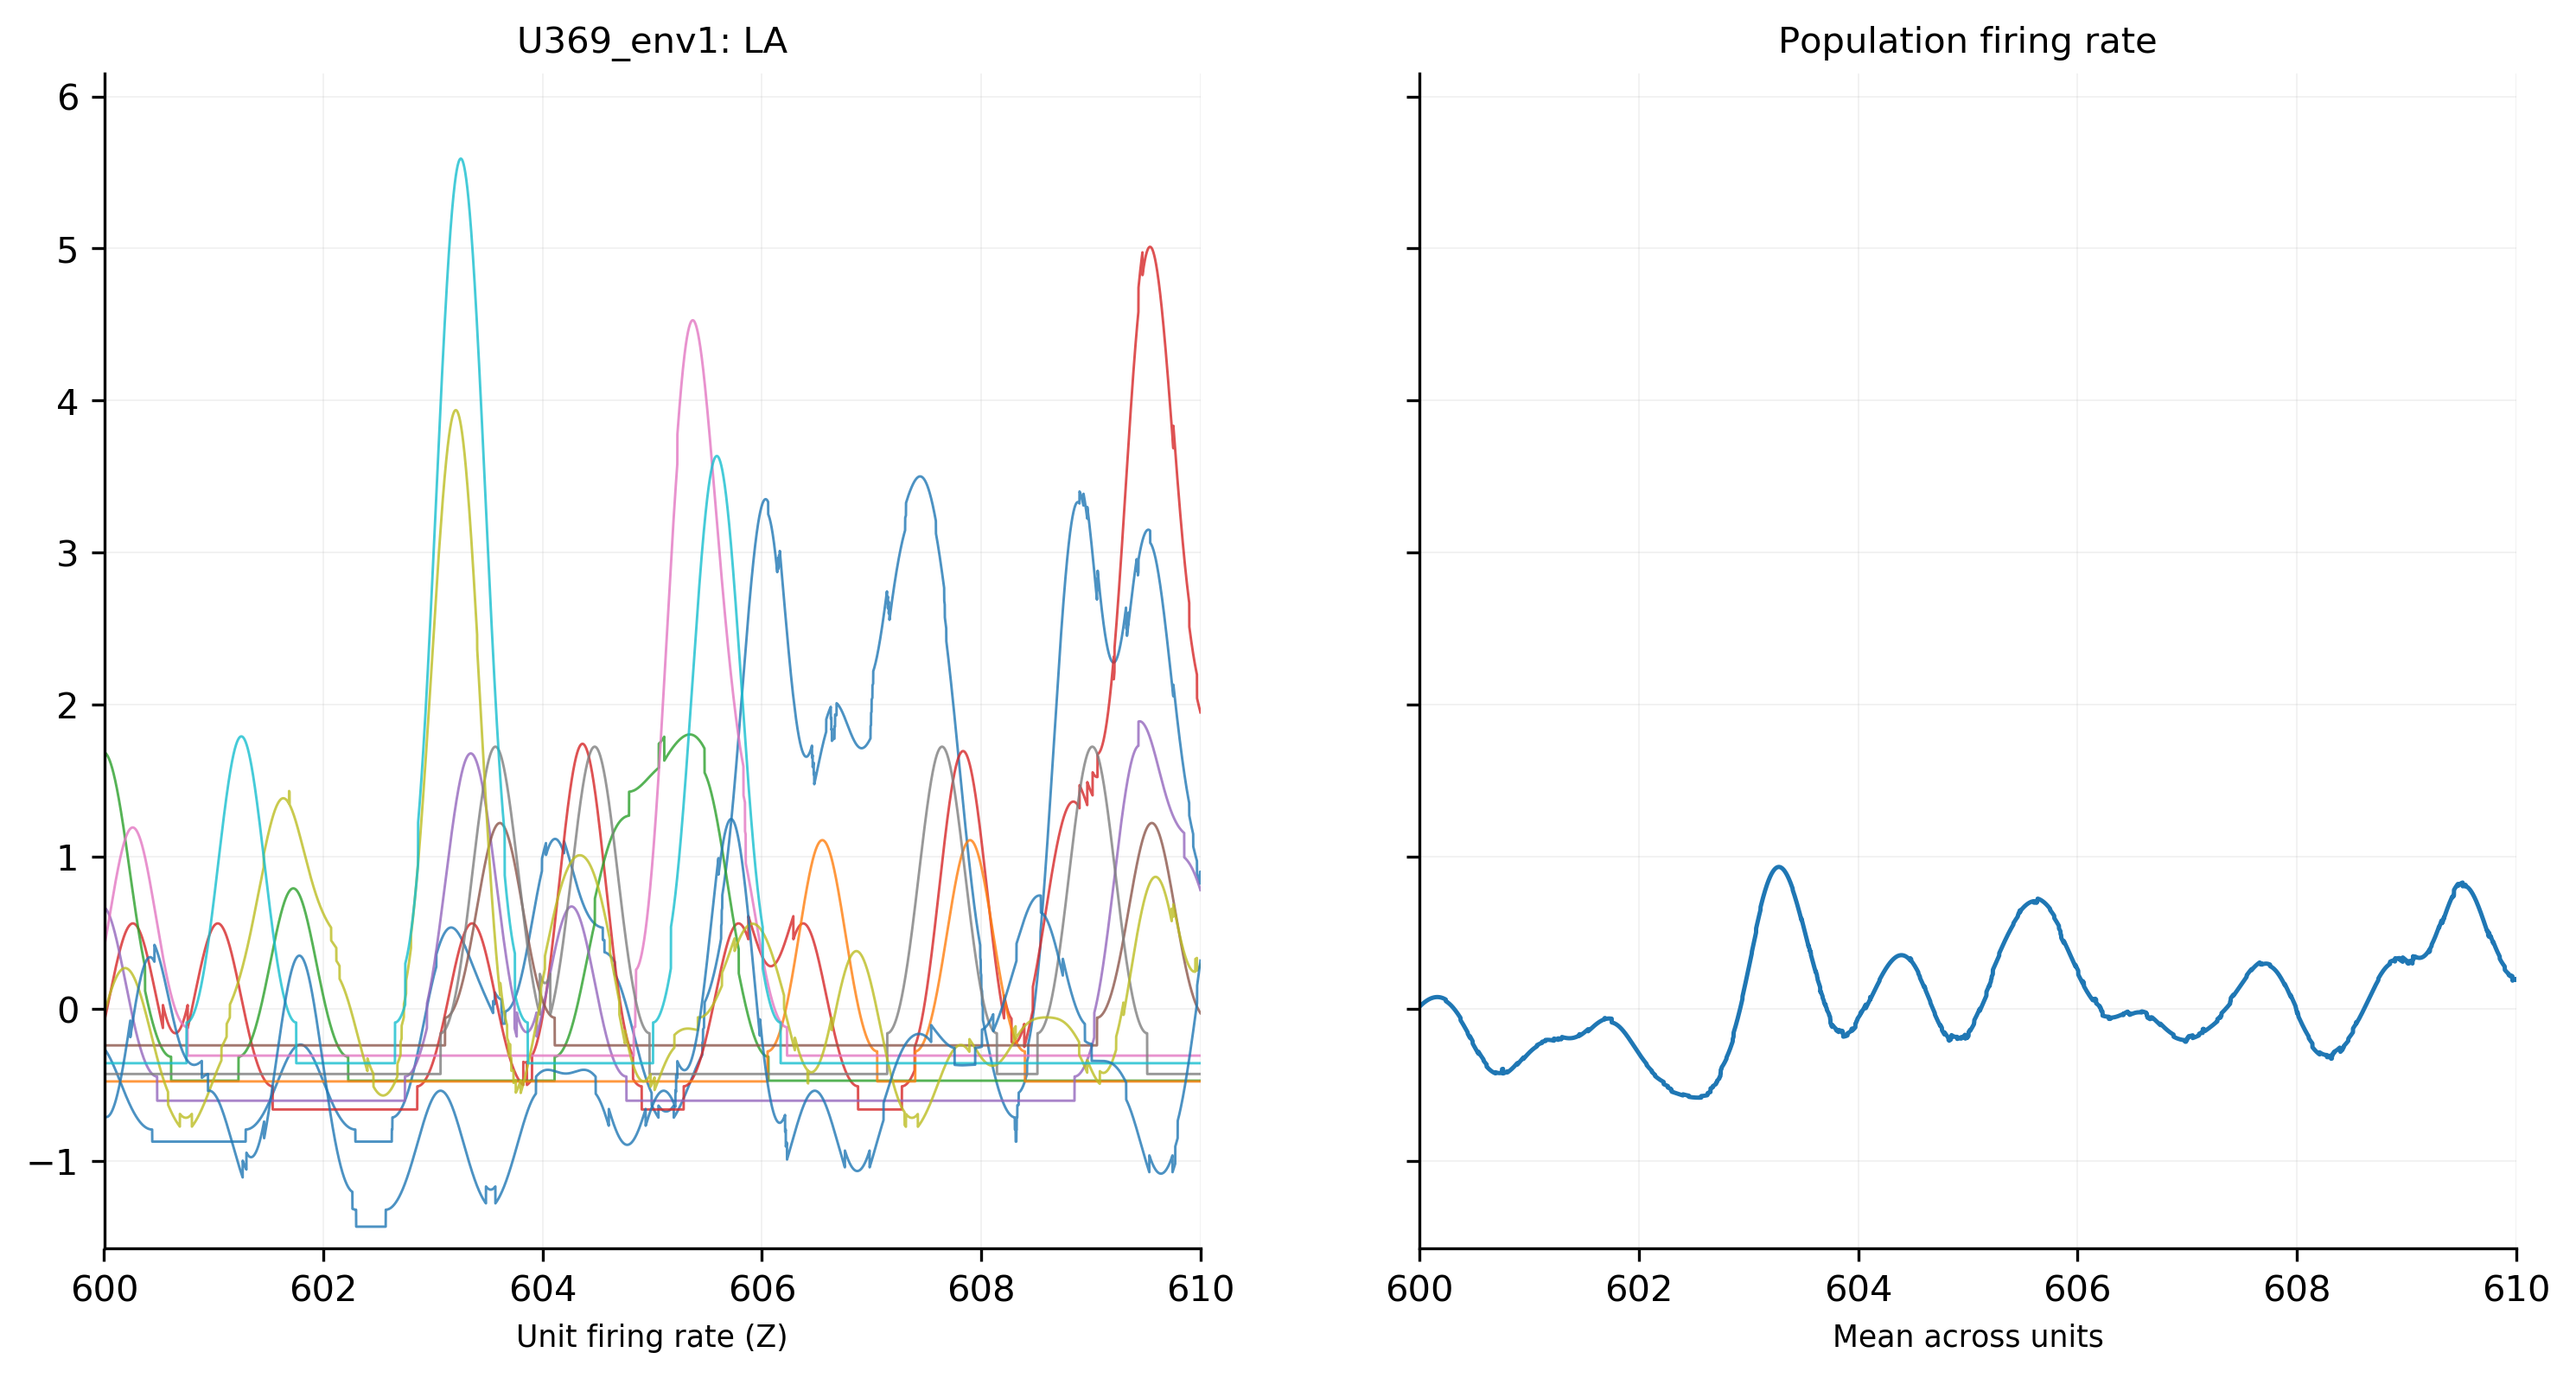

In [510]:
start = 600
duration = 10

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6), dpi=300)
ax = np.ravel(ax)

plot_trace(np.expand_dims(np.mean(zfr, axis=0), axis=0), start=start, duration=duration, 
           x_lab='Mean across units', linewidths=[1.2],
           x_units='secs', fig=fig, ax=ax[1], title='Population firing rate')

plot_trace(zfr, start=start, duration=duration, x_units='secs', x_lab='Unit firing rate (Z)', 
           linewidths=[0.7]*len(zfr), alphas=[0.8]*len(zfr),
           fig=fig, ax=ax[0], title='{}: {}'.format(subj_sess, roi))

f = os.path.join(figure_dir, 'population_firing_rate_construction_{}_{}.png'.format(subj_sess, roi))
fig.savefig(f)

## Collapse 2000Hz power values into epochs of several durations

In [782]:
# Get the mean raw power at each frequency across time,
# within each epoch. Create 100ms epochs, then delete the giant
# 2000Hz power files.
epoch_rates = [10, 2, 1, 0.5, 0.2]

start_time = time()
for subj_sess in sorted(epoch_power.keys()):
    for roi in sorted(epoch_power[subj_sess].keys()):
        # Load the input power file.
        powerf = os.path.join(data_dir, 'virtual_lfp', 'morlet', '{}_{}_power_width5_2-200Hz-50log10steps.hdf'.format(subj_sess, roi))
        power = TimeSeries.from_hdf(powerf).squeeze() # frequency x time
        powerdat = power.data
        n_timepoints = len(power.time)
        sampling_rate = float(power.samplerate)
        
        for epoch_rate in epoch_rates:
            cut = int(np.ceil((sampling_rate*1.5) / (sampling_rate/epoch_rate)))

            # Get time bins, cutting the first and last 1.5secs of data.
            time_bins = manning_utils.get_epochs(np.arange(n_timepoints), epoch_size=(sampling_rate/epoch_rate), cut=cut)

            # Epoch the power data.
            epower = []
            for start, stop in time_bins:
                epower.append(np.mean(powerdat[:, start:stop], axis=1))
            epower = TimeSeries(np.array(epower), name=power.name, 
                                dims=['epoch', 'frequency'],
                                coords={'epoch': np.arange(len(time_bins)), 
                                        'frequency': power.frequency.data,
                                        'samplerate': epoch_rate},
                                attrs={'region': str(power.region.data),
                                       'lfp_start_stop': [time_bins[0][0], time_bins[-1][1]],
                                       'morlet_width': power.morlet_width})

            epoch_power_file = os.path.join(data_dir, 'virtual_lfp', 'morlet', 
                                            '{}_{}_power_width5_2-200Hz-50log10steps_{}Hz-epochs.hdf'.format(subj_sess, roi, epoch_rate))
            epower.to_hdf(epoch_power_file)
        
        # Remove the large power file.
        os.remove(powerf)
            
print('Done in {:.0f} secs'.format(time() - start_time))

Done in 2414 secs


## Epoch firing rate and power data

In [845]:
# Epoch firing rate for each region.

epoch_rate = 2 # duration of each epoch, in Hz
save_outputs = True

start_time = time()
epoch_fr = OrderedDict()
epoch_frz = OrderedDict()
for subj_sess in sessions:
    with open(os.path.join(data_dir, 'spikes', '{}_session_spikes.pkl'.format(subj_sess)), 'rb') as f:
        spikes = pickle.load(f) 
    fr_df, clus_to_chan, chan_to_clus = manning_analysis.get_fr_df(subj_sess, spikes)
    n_timepoints = len(fr_df.fr.iat[0])
    sampling_rate = 2000.
    time_bins = manning_utils.get_epochs(np.arange(n_timepoints), epoch_size=(sampling_rate/epoch_rate))
    rois = sorted(keep_chans[subj_sess].keys())
    for roi in rois:
        # Z-score firing rates for each cluster across time.
        fr_roi_df = fr_df.loc[fr_df.location==roi]
        fr = np.array(fr_roi_df.fr.tolist()) # cluster x time
        fr = fr.T # flip to time x cluster
        zfr = (fr - np.mean(fr, axis=0)) / np.std(fr, axis=0)
        zfr = zfr.T # back to cluster x time
        fr = fr.T # back to cluster x time
        
        # Get the mean firing rate across clusters and time, 
        # within each epoch (weighting units according to their
        # normal firing rates).
        epoch_fr_roi = []
        for start, stop in time_bins:
            epoch_fr_roi.append(np.mean(fr[:, start:stop]))
        epoch_fr.setdefault(subj_sess, OrderedDict())[roi] = np.array(epoch_fr_roi)
        
        # Get the mean firing rate across clusters and time, 
        # within each epoch (weighting all units equally).
        epoch_fr_roi = []
        for start, stop in time_bins:
            epoch_fr_roi.append(np.mean(zfr[:, start:stop]))
        epoch_frz.setdefault(subj_sess, OrderedDict())[roi] = np.array(epoch_fr_roi)
        
# Save outputs.
if save_outputs:
    fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'epoch_fr_mean-unit-FR_{}Hz.pkl'.format(epoch_rate))
    with open(fname, 'wb') as f:
        pickle.dump(epoch_fr, f, pickle.HIGHEST_PROTOCOL)
    print('Saved epoch_fr as {}'.format(fname))
    
    fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'epoch_fr_mean-Z-unit-FR_{}Hz.pkl'.format(epoch_rate))
    with open(fname, 'wb') as f:
        pickle.dump(epoch_frz, f, pickle.HIGHEST_PROTOCOL)
    print('Saved epoch_fr as {}'.format(fname))

print('Done in {:.0f} secs'.format(time() - start_time))

Saved epoch_fr as /data3/scratch/dscho/frLfp/data/virtual_lfp/epoch/epoch_fr_mean-unit-FR_2Hz.pkl
Saved epoch_fr as /data3/scratch/dscho/frLfp/data/virtual_lfp/epoch/epoch_fr_mean-Z-unit-FR_2Hz.pkl
Done in 509 secs


Text(0.5,1,'Correlation across epochs between population firing rate measures (Z or no Z)')

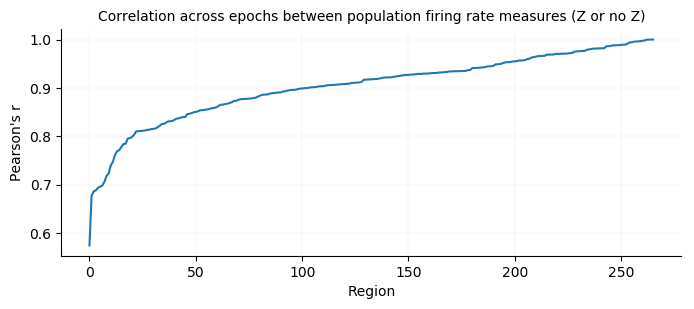

In [891]:
# How well correlated are these firing rate measures?
v1 = []
v2 = []
rs = []
for subj_sess in sorted(epoch_fr.keys()):
    for roi in sorted(epoch_fr[subj_sess].keys()):
        v1 += list(epoch_fr[subj_sess][roi])
        v2 += list(epoch_frz[subj_sess][roi])
        rs.append(stats.pearsonr(epoch_fr[subj_sess][roi], epoch_frz[subj_sess][roi])[0])

fig, ax = plt.subplots(figsize=(8, 3), dpi=100)
ax = np.ravel(ax)
ax[0].plot(np.sort(rs), linewidth=1.5)
ax[0].set_xlabel('Region', fontsize=10)
ax[0].set_ylabel("Pearson's r", fontsize=10)
ax[0].set_title('Correlation across epochs between population firing rate measures (Z or no Z)')

In [ ]:
# # Epoch firing rate and power band data for each region.

# epoch_rate = 2 # duration of each epoch, in Hz
# log_epoched_power = True
# save_outputs = True
# freqs, bands = manning_utils.get_freqs(2, 200, 50)

# start_time = time()
# X = sm.add_constant(np.log10(freqs)) # indepedent variable for robust regression model
# epoch_power = OrderedDict()
# for subj_sess in sessions:
#     with open(os.path.join(data_dir, 'spikes', '{}_session_spikes.pkl'.format(subj_sess)), 'rb') as f:
#         spikes = pickle.load(f) 
#     fr_df, clus_to_chan, chan_to_clus = manning_analysis.get_fr_df(subj_sess, spikes)
#     n_timepoints = len(fr_df.fr.iat[0])
#     sampling_rate = 2000.
#     time_bins = manning_utils.get_epochs(np.arange(n_timepoints), epoch_size=(sampling_rate/epoch_rate))
#     rois = sorted(keep_chans[subj_sess].keys())
#     epoch_fr[subj_sess] = OrderedDict()
#     epoch_power[subj_sess] = OrderedDict()
#     for roi in rois:
#         # Z-score firing rates for each cluster across time.
#         fr_roi_df = fr_df.loc[fr_df.location==roi]
#         fr = np.array(fr_roi_df.fr.tolist()) # cluster x time
#         fr = fr.T # flip to time x cluster
#         zfr = (fr - np.mean(fr, axis=0)) / np.std(fr, axis=0)
#         zfr = zfr.T # back to cluster x time
        
#         # Get the mean firing rate across clusters and time, 
#         # within each epoch.
#         epoch_fr_roi = []
#         for start, stop in time_bins:
#             epoch_fr_roi.append(np.mean(zfr[:, start:stop]))
#         epoch_fr[subj_sess][roi] = np.array(epoch_fr_roi)
        
#         # Get the mean raw power at each frequency across time,
#         # within each epoch.
#         powerf = os.path.join(data_dir, 'virtual_lfp', 'morlet', '{}_{}_power_width5_2-200Hz-50log10steps.hdf'.format(subj_sess, roi))
#         power = TimeSeries.from_hdf(powerf).squeeze().data # frequency x time
#         epoch_power_roi = []
#         for start, stop in time_bins:
#             epoch_power_roi.append(np.mean(power[:, start:stop], axis=1))
#         epoch_power_roi = np.array(epoch_power_roi) # time x freq
        
#         # Log-transform epoched power values.
#         if log_epoched_power:
#             epoch_power_roi = np.log10(epoch_power_roi)
            
#         # Z-score epoched power values 1) across time and frequency (_za) and
#         # 2) at each frequency, across time (_zw).
#         epoch_power_roi_ = epoch_power_roi.copy() # keep a copy of epoched power before Z-scoring
#         epoch_power_roi_za = (epoch_power_roi - np.mean(epoch_power_roi)) / np.std(epoch_power_roi)
#         epoch_power_roi_zw = (epoch_power_roi - np.mean(epoch_power_roi, axis=0)) / np.std(epoch_power_roi, axis=0)
        
#         # Get narrow and broadband power measures (mean of Z-scored, epoched power values
#         # across the relevant frequencies).
#         epoch_power[subj_sess][roi] = OrderedDict([
#                 ('delta', np.mean(epoch_power_roi_zw[:, np.isin(freqs, bands['delta'])], axis=1)),
#                 ('theta', np.mean(epoch_power_roi_zw[:, np.isin(freqs, bands['theta'])], axis=1)),
#                 ('alpha', np.mean(epoch_power_roi_zw[:, np.isin(freqs, bands['alpha'])], axis=1)),
#                 ('beta', np.mean(epoch_power_roi_zw[:, np.isin(freqs, bands['beta'])], axis=1)),
#                 ('gamma', np.mean(epoch_power_roi_zw[:, np.isin(freqs, bands['gamma'])], axis=1)),
#                 ('allfreq', np.mean(epoch_power_roi_zw, axis=1))
#             ])
        
#         # Get tilt and broadband power by iterating over epochs and fitting
#         # a robust regression model to powers at different frequencies.
#         #
#         # tilt = slope of the model fit to epoched raw power values
#         #
#         # broadband power = mean predicted value of the model fit to Z-scored
#         #                   (within each frequency) epoched power values
#         tilts = []
#         bband_powers = []
#         for i in range(epoch_power_roi.shape[0]):
#             y = epoch_power_roi_za[i, :]
#             huber_t = sm.RLM(y, X, M=sm.robust.norms.HuberT())
#             hub_results = huber_t.fit()
#             intercept, slope = hub_results.params
#             tilts.append(slope)
        
#             y = epoch_power_roi_zw[i, :]
#             huber_t = sm.RLM(y, X, M=sm.robust.norms.HuberT())
#             hub_results = huber_t.fit()
#             bband_powers.append(np.mean(hub_results.predict()))
#         epoch_power[subj_sess][roi]['tilt'] = np.array(tilts)
#         epoch_power[subj_sess][roi]['bband_power'] = np.array(bband_powers)
        
# # Save outputs.
# if save_outputs:
#     fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'epoch_fr_{}Hz.pkl'.format(epoch_rate))
#     with open(fname, 'wb') as f:
#         pickle.dump(epoch_fr, f, pickle.HIGHEST_PROTOCOL)
#     print('Saved epoch_fr as {}'.format(fname))

#     fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'epoch_power_{}Hz.pkl'.format(epoch_rate))
#     with open(fname, 'wb') as f:
#         pickle.dump(epoch_power, f, pickle.HIGHEST_PROTOCOL)
#     print('Saved epoch_power as {}'.format(fname))

# print('Done in {:.0f} secs'.format(time() - start_time))

In [905]:
# Epoch power at each frequency, for each region.

epoch_rate = 2 # duration of each epoch, in Hz
save_outputs = True
freqs, bands = manning_utils.get_freqs(2, 200, 50)

start_time = time()
epoch_power_freqs_zw = OrderedDict()
epoch_power_freqs_za = OrderedDict()
X = sm.add_constant(np.log10(freqs)) # indepedent variable for robust regression model
epoch_power = OrderedDict()
for subj_sess in sessions:
    rois = sorted(keep_chans[subj_sess].keys())
    for roi in rois:
        epoch_powerf = os.path.join(data_dir, 'virtual_lfp', 'morlet', 
                                    '{}_{}_power_width5_2-200Hz-50log10steps_{}Hz-epochs.hdf'
                                    .format(subj_sess, roi, epoch_rate))
        epoch_power_roi = TimeSeries.from_hdf(epoch_powerf).data
        
        # Log-transform epoched power values.
        epoch_power_roi = np.log10(epoch_power_roi)
        
        # Z-score epoched power values within each frequency, across time.
        epoch_power_roi_zw = (epoch_power_roi - np.mean(epoch_power_roi, axis=0)) / np.std(epoch_power_roi, axis=0)
        epoch_power_freqs_zw.setdefault(subj_sess, OrderedDict())[roi] = epoch_power_roi_zw
        
        # Z-score epoched power values across frequency and time.
        epoch_power_roi_za = (epoch_power_roi - np.mean(epoch_power_roi)) / np.std(epoch_power_roi)
        epoch_power_freqs_za.setdefault(subj_sess, OrderedDict())[roi] = epoch_power_roi_za
        
        # Get narrow and broadband power measures (mean of Z-scored, epoched power values
        # across the relevant frequencies).
        epoch_power.setdefault(subj_sess, OrderedDict())[roi] = OrderedDict([
                ('delta', np.mean(epoch_power_roi_zw[:, np.isin(freqs, bands['delta'])], axis=1)),
                ('theta', np.mean(epoch_power_roi_zw[:, np.isin(freqs, bands['theta'])], axis=1)),
                ('alpha', np.mean(epoch_power_roi_zw[:, np.isin(freqs, bands['alpha'])], axis=1)),
                ('beta', np.mean(epoch_power_roi_zw[:, np.isin(freqs, bands['beta'])], axis=1)),
                ('gamma', np.mean(epoch_power_roi_zw[:, np.isin(freqs, bands['gamma'])], axis=1)),
                ('allfreq', np.mean(epoch_power_roi_zw, axis=1))
            ])
        
        # Get tilt and broadband power by iterating over epochs and fitting
        # a robust regression model to powers at different frequencies.
        #
        # tilt = slope of a model fit to epoched log-power values, Z-scored
        #        across epochs and frequencies
        #
        # broadband power = mean predicted value of a model fit to log-power
        #                   values, Z-scored across epochs within each frequency
        tilts = []
        bband_powers = []
        for i in range(epoch_power_roi.shape[0]):
            y = epoch_power_roi_za[i, :]
            huber_t = sm.RLM(y, X, M=sm.robust.norms.HuberT())
            hub_results = huber_t.fit()
            intercept, slope = hub_results.params
            tilts.append(slope)
        
            y = epoch_power_roi_zw[i, :]
            huber_t = sm.RLM(y, X, M=sm.robust.norms.HuberT())
            hub_results = huber_t.fit()
            bband_powers.append(np.mean(hub_results.predict()))
        epoch_power[subj_sess][roi]['tilt'] = np.array(tilts)
        epoch_power[subj_sess][roi]['bband_power'] = np.array(bband_powers)
        
# Save outputs.
if save_outputs:
    fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'epoch_power_freqs_log_Z-withinfreq_{}Hz.pkl'.format(epoch_rate))
    with open(fname, 'wb') as f:
        pickle.dump(epoch_power_freqs_zw, f, pickle.HIGHEST_PROTOCOL)
    print('Saved epoch_power_freqs_zw as {}'.format(fname))
    
    fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'epoch_power_freqs_log_Z-acrossfreq_{}Hz.pkl'.format(epoch_rate))
    with open(fname, 'wb') as f:
        pickle.dump(epoch_power_freqs_za, f, pickle.HIGHEST_PROTOCOL)
    print('Saved epoch_power_freqs_za as {}'.format(fname))
    
    fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'epoch_power_{}Hz.pkl'.format(epoch_rate))
    with open(fname, 'wb') as f:
        pickle.dump(epoch_power, f, pickle.HIGHEST_PROTOCOL)
    print('Saved epoch_power as {}'.format(fname))

print('Done in {:.0f} secs'.format(time() - start_time))

Saved epoch_power_freqs_zw as /data3/scratch/dscho/frLfp/data/virtual_lfp/epoch/epoch_power_freqs_log_Z-withinfreq_2Hz.pkl
Saved epoch_power_freqs_za as /data3/scratch/dscho/frLfp/data/virtual_lfp/epoch/epoch_power_freqs_log_Z-acrossfreq_2Hz.pkl
Done in 31 secs


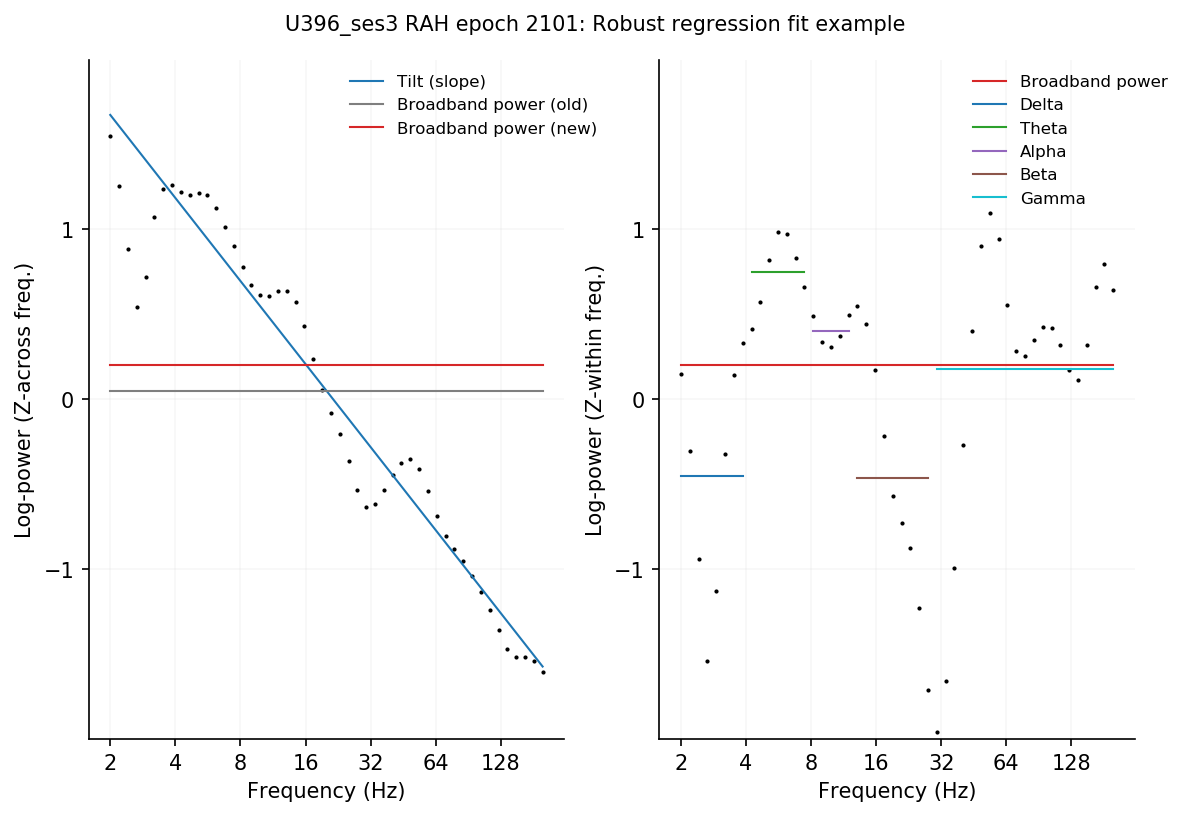

In [325]:
subj_sess = subj_sess
roi = roi
#epochs = random.sample([int(i) for i in np.arange(len(epoch_power[subj_sess][roi]['tilt']))], 1)
freqs, freq_bands = manning_utils.get_freqs(2, 200, 50)
nbands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
nband_colors = ['C0', 'C2', 'C4', 'C5', 'C9']
narrowband_xvals = [np.log10(freq_bands[key]) for key in freq_bands.keys()]

fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(9, 6), dpi=150)
ax = ax.ravel()

n = 1
for i in range(n):
    tilt = epoch_power[subj_sess][roi]['tilt'][epochs[0]]
    bband_power = epoch_power[subj_sess][roi]['bband_power'][epochs[0]]
    X = sm.add_constant(np.log10(freqs))
    y = epoch_power_freqs_za[subj_sess][roi][epochs[0], :]
    huber_t = sm.RLM(y, X, M=sm.robust.norms.HuberT())
    hub_results = huber_t.fit()
    pred = hub_results.predict()
    narrowband_yvals = [epoch_power[subj_sess][roi][nband][epochs[0]] 
                        for nband in nbands]
    
    ax[2*i].plot(np.log10(freqs), epoch_power_freqs_za[subj_sess][roi][epochs[0], :], 
                 color='k', linewidth=0, marker='.', markersize=2)
    ax[2*i].plot(np.log10(freqs), pred, 
                 color='C0', linewidth=1, label='Tilt (slope)')
    ax[2*i].plot(np.log10(freqs), np.repeat(np.mean(pred), len(freqs)), 
                 color='C7', linewidth=1, label='Broadband power (old)')
    ax[2*i].plot(np.log10(freqs), np.repeat(bband_power, len(freqs)), 
                 color='C1', linewidth=1, label='Broadband power (new)')
    
    ax[2*i+1].plot(np.log10(freqs), epoch_power_freqs_zw[subj_sess][roi][epochs[0], :], 
                   color='k', linewidth=0, marker='.', markersize=2)
    ax[2*i+1].plot(np.log10(freqs), np.repeat(bband_power, len(freqs)), 
                   color='C1', linewidth=1, label='Broadband power')
    for j in range(5):
        ax[2*i+1].plot(narrowband_xvals[j], np.repeat(narrowband_yvals[j], len(narrowband_xvals[j])), 
                       color=nband_colors[j], linewidth=1, label=nbands[j].capitalize())
    
    ax[2*i].legend(loc=1, bbox_to_anchor=[1.1, 1], fontsize=8)
    ax[2*i+1].legend(loc=1, bbox_to_anchor=[1.1, 1], fontsize=8)
    
    for j in range(2):
        ax[2*i+j].set_xticks(np.log10([2, 4, 8, 16, 32, 64, 128]))
        ax[2*i+j].set_xticklabels([2, 4, 8, 16, 32, 64, 128])
        ax[2*i+j].set_yticks([-1, 0, 1])
        ax[2*i+j].set_ylim([-2, 2])
        ax[2*i+j].spines['right'].set_visible(False)
        ax[2*i+j].spines['top'].set_visible(False)
        
    if i == n-1:
        ax[2*i].set_xlabel('Frequency (Hz)', fontsize=10)
        ax[2*i+1].set_xlabel('Frequency (Hz)', fontsize=10)
    
    ax[2*i].set_ylabel('Log-power (Z-across freq.)', fontsize=10)
    ax[2*i+1].set_ylabel('Log-power (Z-within freq.)', fontsize=10)
        

fig.suptitle('{} {} epoch {}: Robust regression fit example'.format(subj_sess, roi, epochs[0]), 
             y=0.93, fontsize=10)

f = os.path.join(figure_dir, 'robust_regression_results_9epochs_{}_{}.png'.format(subj_sess, roi))
#fig.savefig(f)

## Power heatmaps by frequency and firing rate percentile

In [914]:
# For each region, sort epochs by firing rate and divide these 
# sorted epochs into 50 bins of equal size. Within each bin,
# calculate the population firing rate and the  Z-scored 
# log-power at each frequency.
start_time = time()
save_outputs = False
epoch_fr_ = epoch_frz
epoch_power_freqs_ = epoch_power_freqs_zw

fr_bin_fr = OrderedDict()
fr_bin_power = OrderedDict()
for subj_sess in sorted(epoch_fr_.keys()):
    rois = sorted(epoch_fr_[subj_sess])
    for roi in rois:
        fr_sort = np.argsort(epoch_fr_[subj_sess][roi])
        fr_bins = np.array_split(fr_sort, 50)
        
        fr_bin_fr_roi = []
        for fr_bin in fr_bins:
            fr_bin_fr_roi.append(np.mean(epoch_fr_[subj_sess][roi][fr_bin]))
        fr_bin_fr_roi = np.array(fr_bin_fr_roi)
        fr_bin_fr.setdefault(subj_sess, OrderedDict())[roi] = fr_bin_fr_roi
        
        fr_bin_power_roi = []
        for fr_bin in fr_bins:
            fr_bin_power_roi.append(np.mean(epoch_power_freqs_[subj_sess][roi][fr_bin], axis=0))
        fr_bin_power_roi = np.array(fr_bin_power_roi).T # frequency x fr_bin
        fr_bin_power.setdefault(subj_sess, OrderedDict())[roi] = fr_bin_power_roi
        
# Save outputs.
if save_outputs:
    fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'fr_bin_fr_{}Hz.pkl'.format(epoch_rate))
    with open(fname, 'wb') as f:
        pickle.dump(fr_bin_fr, f, pickle.HIGHEST_PROTOCOL)
    print('Saved fr_bin_fr as {}'.format(fname))
    
    fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'fr_bin_power_{}Hz.pkl'.format(epoch_rate))
    with open(fname, 'wb') as f:
        pickle.dump(fr_bin_power, f, pickle.HIGHEST_PROTOCOL)
    print('Saved fr_bin_power as {}'.format(fname))

print('Done in {:.0f} secs'.format(time() - start_time))

Done in 1 secs


In [915]:
fr_bin_fr_all = []
for subj_sess in sorted(fr_bin_fr.keys()):
    rois = sorted(fr_bin_fr[subj_sess])
    for roi in rois:
        fr_bin_fr_all.append(fr_bin_fr[subj_sess][roi])
fr_bin_fr_all = np.array(fr_bin_fr_all)

fr_bin_power_all = []
for subj_sess in sorted(fr_bin_power.keys()):
    rois = sorted(fr_bin_power[subj_sess])
    for roi in rois:
        fr_bin_power_all.append(fr_bin_power[subj_sess][roi])
fr_bin_power_all = np.array(fr_bin_power_all)

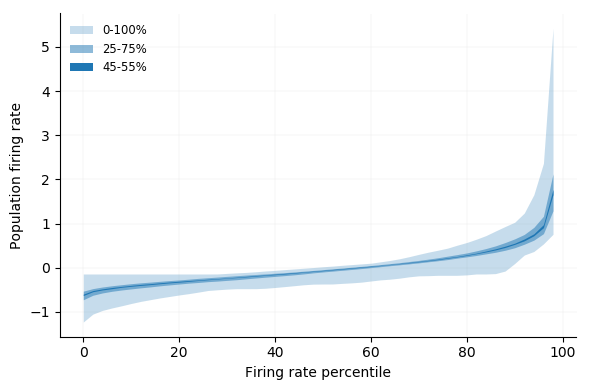

In [870]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
ax = np.ravel(ax)

xvals = np.arange(fr_bin_fr_all.shape[1])

ax[0].fill_between(xvals, 
                   np.percentile(fr_bin_fr_all, 0, axis=0),
                   np.percentile(fr_bin_fr_all, 100, axis=0),
                   color='C0', alpha=0.25, linewidth=0, label='0-100%')
ax[0].fill_between(xvals, 
                   np.percentile(fr_bin_fr_all, 25, axis=0),
                   np.percentile(fr_bin_fr_all, 75, axis=0),
                   color='C0', alpha=0.5, linewidth=0, label='25-75%')
ax[0].fill_between(xvals, 
                   np.percentile(fr_bin_fr_all, 45, axis=0),
                   np.percentile(fr_bin_fr_all, 55, axis=0),
                   color='C0', alpha=1, linewidth=0, label='45-55%')

ax[0].set_xticks(np.linspace(0, 50, 6))
ax[0].set_xticklabels([2*int(i) for i in np.linspace(0, 50, 6)], fontsize=10, rotation=0)
ax[0].set_xlabel('Firing rate percentile', fontsize=10)
ax[0].set_ylabel('Population firing rate', fontsize=10)
ax[0].legend(loc=2)

fig.tight_layout()
f = os.path.join(figure_dir, 'population_FR_mean-Z-unit-FR_{}_regions.png'.format(fr_bin_fr_all.shape[0]))
#fig.savefig(f)

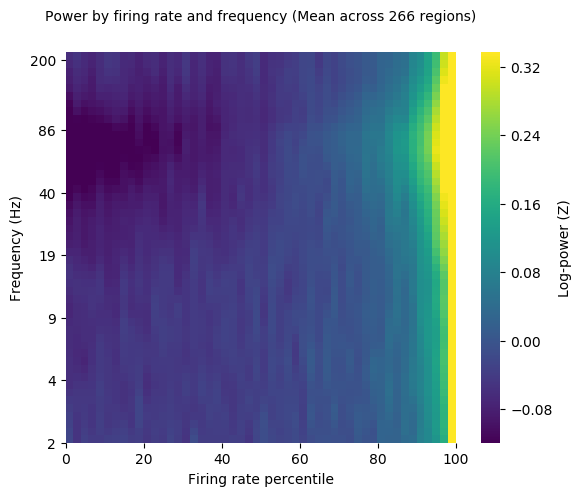

In [488]:
dat = np.mean(fr_bin_power_all, axis=0)
#dat = fr_bin_power['U379_ses1']['RpSMA']

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
ax = np.ravel(ax)

#cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap = 'viridis'

ax[0] = sns.heatmap(dat,
            ax=ax[0],
            cmap=cmap,
            vmin=np.percentile(dat, 2.5),
            #center=np.percentile(dat, 50),
            vmax=np.percentile(dat, 97.5),
            square=True)

ax[0].invert_yaxis()
_ = ax[0].set_xticks(np.linspace(0, 50, 6))
_ = ax[0].set_xticklabels([2*int(i) for i in np.linspace(0, 50, 6)], fontsize=10, rotation=0)
_ = ax[0].set_xlabel('Firing rate percentile', fontsize=10)

inds = list([int(i) for i in np.linspace(0, 49, 7)])
_ = ax[0].set_yticks(inds)
_ = ax[0].set_yticklabels([int(round(i, 0)) for i in freqs[inds]], fontsize=10, rotation=0)
_ = ax[0].set_ylabel('Frequency (Hz)', fontsize=10)

cbar = ax[0].collections[0].colorbar
cbar.set_label('Log-power (Z)', rotation=90, fontsize=10)

_ = ax[0].set_title('Power by firing rate and frequency (Mean across {} regions)'.format(fr_bin_power_all.shape[0]), fontsize=10, y=1.06)

fig.tight_layout()
f = os.path.join(figure_dir, 'firing_rate_correlated_with_power_at_each_frequency_{}_regions.png'.format(fr_bin_power_all.shape[0]))
#fig.savefig(f)

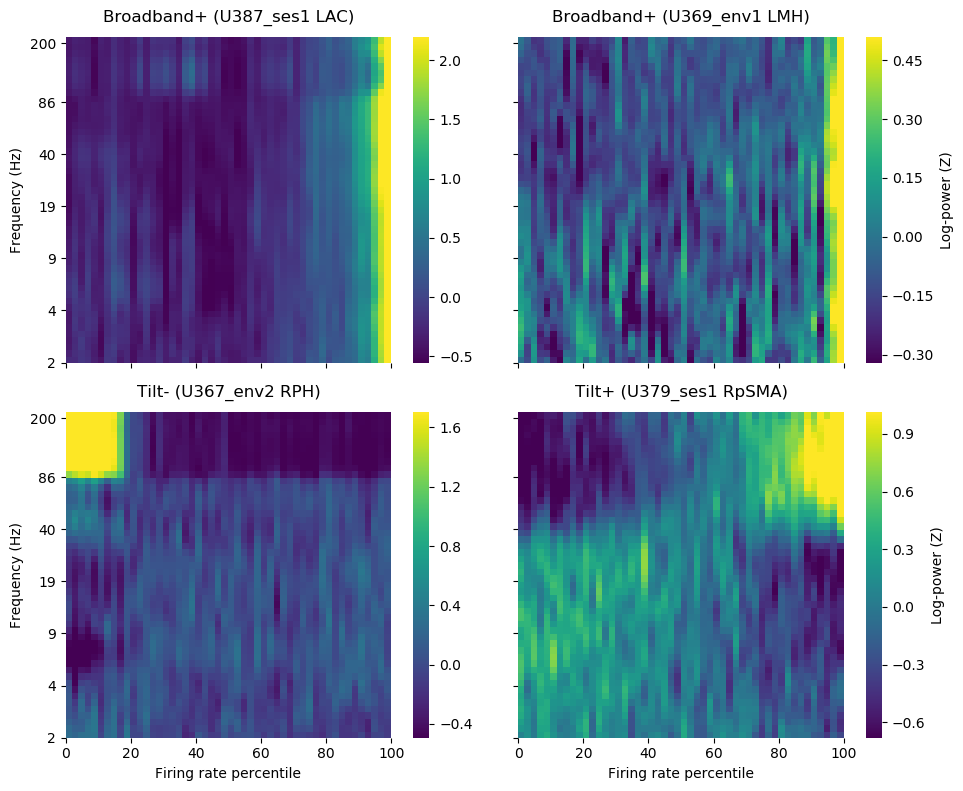

In [918]:
rois = [('U387_ses1', 'LAC'),
        ('U369_env1', 'LMH'),
        ('U367_env2', 'RPH'),
        ('U379_ses1', 'RpSMA')]
roi_labels = ['Broadband+', 'Broadband+', 'Tilt-', 'Tilt+']

# Set up the matplotlib figure
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8), dpi=100)
ax = np.ravel(ax)

#cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap = 'viridis'

for i in range(len(rois)):
    subj_sess, roi = rois[i]
    dat = fr_bin_power[subj_sess][roi]
    sns.heatmap(dat, ax=ax[i],
                cmap=cmap,
                vmin=np.percentile(dat, 2.5),
                #center=np.percentile(dat, 50),
                vmax=np.percentile(dat, 97.5),
                square=True)
    
    ax[i].invert_yaxis()
    
    if i in (0, 1, 2, 3):
        inds = list([int(i) for i in np.linspace(0, 49, 7)])
        _ = ax[i].set_yticks(inds)
        _ = ax[i].set_yticklabels([int(round(i, 0)) for i in freqs[inds]], fontsize=10, rotation=0)
       
    if i in (0, 2):
        _ = ax[i].set_ylabel('Frequency (Hz)', fontsize=10)
        
    if i in (2, 3):
        _ = ax[i].set_xticks(np.linspace(0, 50, 6))
        _ = ax[i].set_xticklabels([2*int(i) for i in np.linspace(0, 50, 6)], fontsize=10, rotation=0)
        _ = ax[i].set_xlabel('Firing rate percentile', fontsize=10)

    if i in (1, 3):
        cbar = ax[i].collections[0].colorbar
        cbar.set_label('Log-power (Z)', rotation=90, fontsize=10)

    _ = ax[i].set_title('{} ({} {})'.format(roi_labels[i], subj_sess, roi), fontsize=12, y=1.02)

fig.tight_layout()
f = os.path.join(figure_dir, 'firing_rate_correlated_with_power_at_each_frequency_4_regions.png')
#fig.savefig(f)

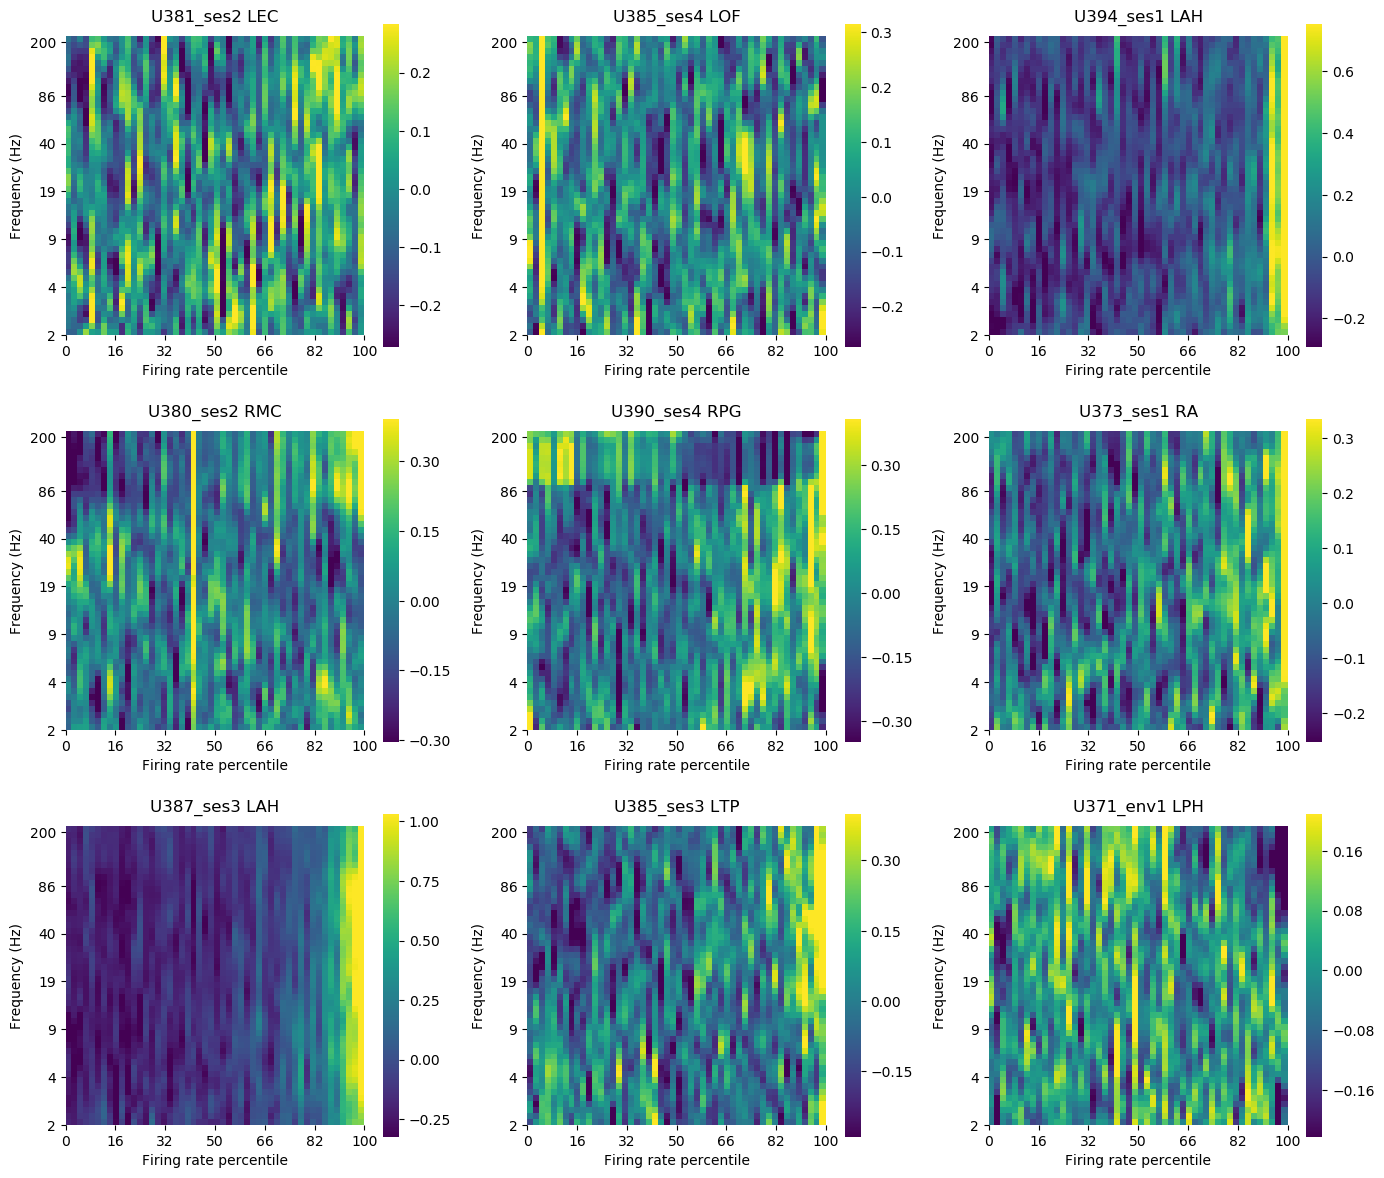

In [491]:
keys = []
for subj_sess in sorted(fr_bin_power.keys()):
    for roi in sorted(fr_bin_power[subj_sess]):
        keys.append((subj_sess, roi))
rand_rois = random.sample(keys, 9)

# Set up the matplotlib figure
fig, ax = plt.subplots(3, 3, figsize=(14, 12), dpi=100)
ax = np.ravel(ax)

#cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap = 'viridis'

for i in range(len(rand_rois)):
    subj_sess, roi = rand_rois[i]
    dat = fr_bin_power[subj_sess][roi]
    sns.heatmap(dat, ax=ax[i],
                cmap=cmap,
                vmin=np.percentile(dat, 2.5),
                #center=np.percentile(dat, 50),
                vmax=np.percentile(dat, 97.5),
                square=True)

    ax[i].invert_yaxis()
    _ = ax[i].set_xticks(np.linspace(0, 50, 7))
    _ = ax[i].set_xticklabels([2*int(i) for i in np.linspace(0, 50, 7)], fontsize=10, rotation=0)
    _ = ax[i].set_xlabel('Firing rate percentile', fontsize=10)

    inds = list([int(i) for i in np.linspace(0, 49, 7)])
    _ = ax[i].set_yticks(inds)
    _ = ax[i].set_yticklabels([int(round(i, 0)) for i in freqs[inds]], fontsize=10, rotation=0)
    _ = ax[i].set_ylabel('Frequency (Hz)', fontsize=10)

    _ = ax[i].set_title('{} {}'.format(subj_sess, roi), fontsize=12, y=1.02)

fig.tight_layout()

## Pearson correlations between power at each frequency and firing rate, for each region

In [315]:
# Calculate Pearson correlations between firing rate and
# power at each frequency, for each region.
save_outputs = True
epoch_fr_ = epoch_frz

start = time()
freqfr_corrs = OrderedDict()
for subj_sess in sorted(epoch_fr_.keys()):
    for roi in sorted(epoch_fr_[subj_sess]):
        r_vec = []
        fr_vec = epoch_fr_[subj_sess][roi]
        for ifreq in range(epoch_power_freqs[subj_sess][roi].shape[1]):
            r_vec.append(stats.pearsonr(fr_vec, epoch_power_freqs[subj_sess][roi][:, ifreq])[0])
        r_vec = np.array(r_vec) # vector of Pearson correlations between firing rate and power at each frequency
        freqfr_corrs.setdefault(subj_sess, OrderedDict())[roi] = r_vec

if save_outputs:
    fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'freqfr_corrs_{}Hz.pkl'.format(epoch_rate))
    with open(fname, 'wb') as f:
        pickle.dump(freqfr_corrs, f, pickle.HIGHEST_PROTOCOL)
    print('Saved freqfr_corrs as {}'.format(fname))

print('Done in {:.0f} secs'.format(time() - start))   

Saved freqfr_corrs as /data3/scratch/dscho/frLfp/data/virtual_lfp/epoch/freqfr_corrs_2Hz.pkl
Done in 2 secs


In [317]:
rvecs = []
for subj_sess in sorted(epoch_fr_.keys()):
    for roi in sorted(epoch_fr_[subj_sess]):
        rvecs.append(freqfr_corrs[subj_sess][roi])
rvecs = np.array(rvecs)

In [356]:
#powfr_corr_df.query("(power_measure=='bband_power') & (significance=='pos')").sort_values('rval')
keys = powfr_corr_df.loc[powfr_corr_df.power_measure=='bband_power'].sort_values(by='rval')[['subj_sess', 'roi']].values.tolist()

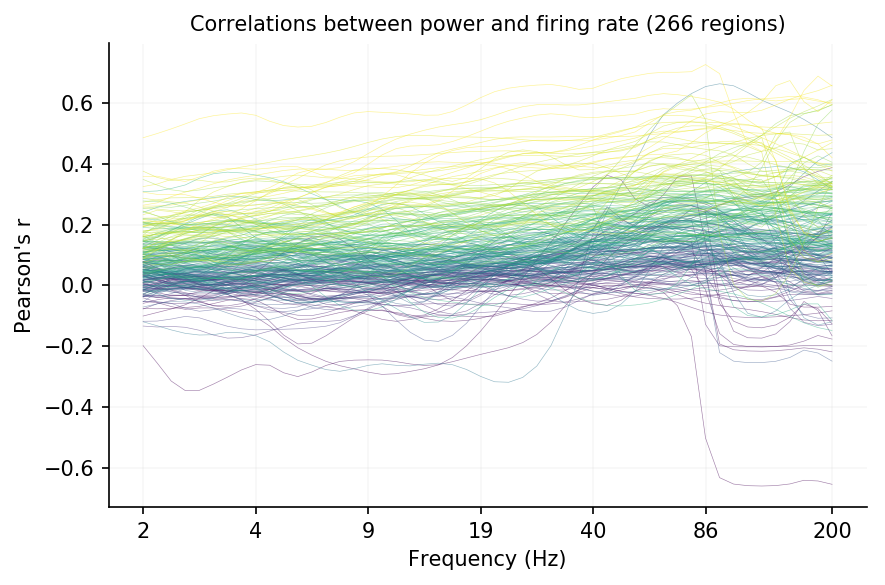

In [552]:
# Get all ROIs sorted by their correlation between firing rate and broadband power
keys = powfr_corr_df.loc[powfr_corr_df.power_measure=='bband_power'].sort_values(by='rval')[['subj_sess', 'roi']].values.tolist()
#keys = powfr_corr_df.query("(power_measure=='tilt') & (significance=='neg')").sort_values(by='rval')[['subj_sess', 'roi']].values.tolist()
rvecs = []
for i in range(len(keys)):
    subj_sess, roi = keys[i]
    rvecs.append(freqfr_corrs[subj_sess][roi])
rvecs = np.array(rvecs)

colors = sns.color_palette('viridis', len(keys))
#colors = sns.diverging_palette(220, 10, n=n_rois)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
ax = np.ravel(ax)

n_rois = rvecs.shape[0]
n_freqs = rvecs.shape[1]

xvals = np.arange(n_freqs)
for i in range(n_rois):
    ax[0].plot(xvals, 
               rvecs[i, :], 
               linewidth=0.3,
               alpha=0.5,
               color=colors[i])

inds = list([int(i) for i in np.linspace(0, 49, 7)])
ax[0].set_xticks(inds)
ax[0].set_xticklabels([int(round(i, 0)) for i in freqs[inds]], fontsize=10, rotation=0)
ax[0].set_xlabel('Frequency (Hz)', fontsize=10)
ax[0].set_ylabel("Pearson's r", fontsize=10)
ax[0].set_title(('Correlations between power and firing rate ({} regions)'.format(n_rois)))

fig.tight_layout()
f = os.path.join(figure_dir, 'firing_rate_correlated_with_power_at_each_frequency_{}_regions_expanded.png'.format(n_rois))
#fig.savefig(f)

In [896]:
nbands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
powfr_corr_df['nband'] = powfr_corr_df.power_measure.apply(lambda x: x in nbands)

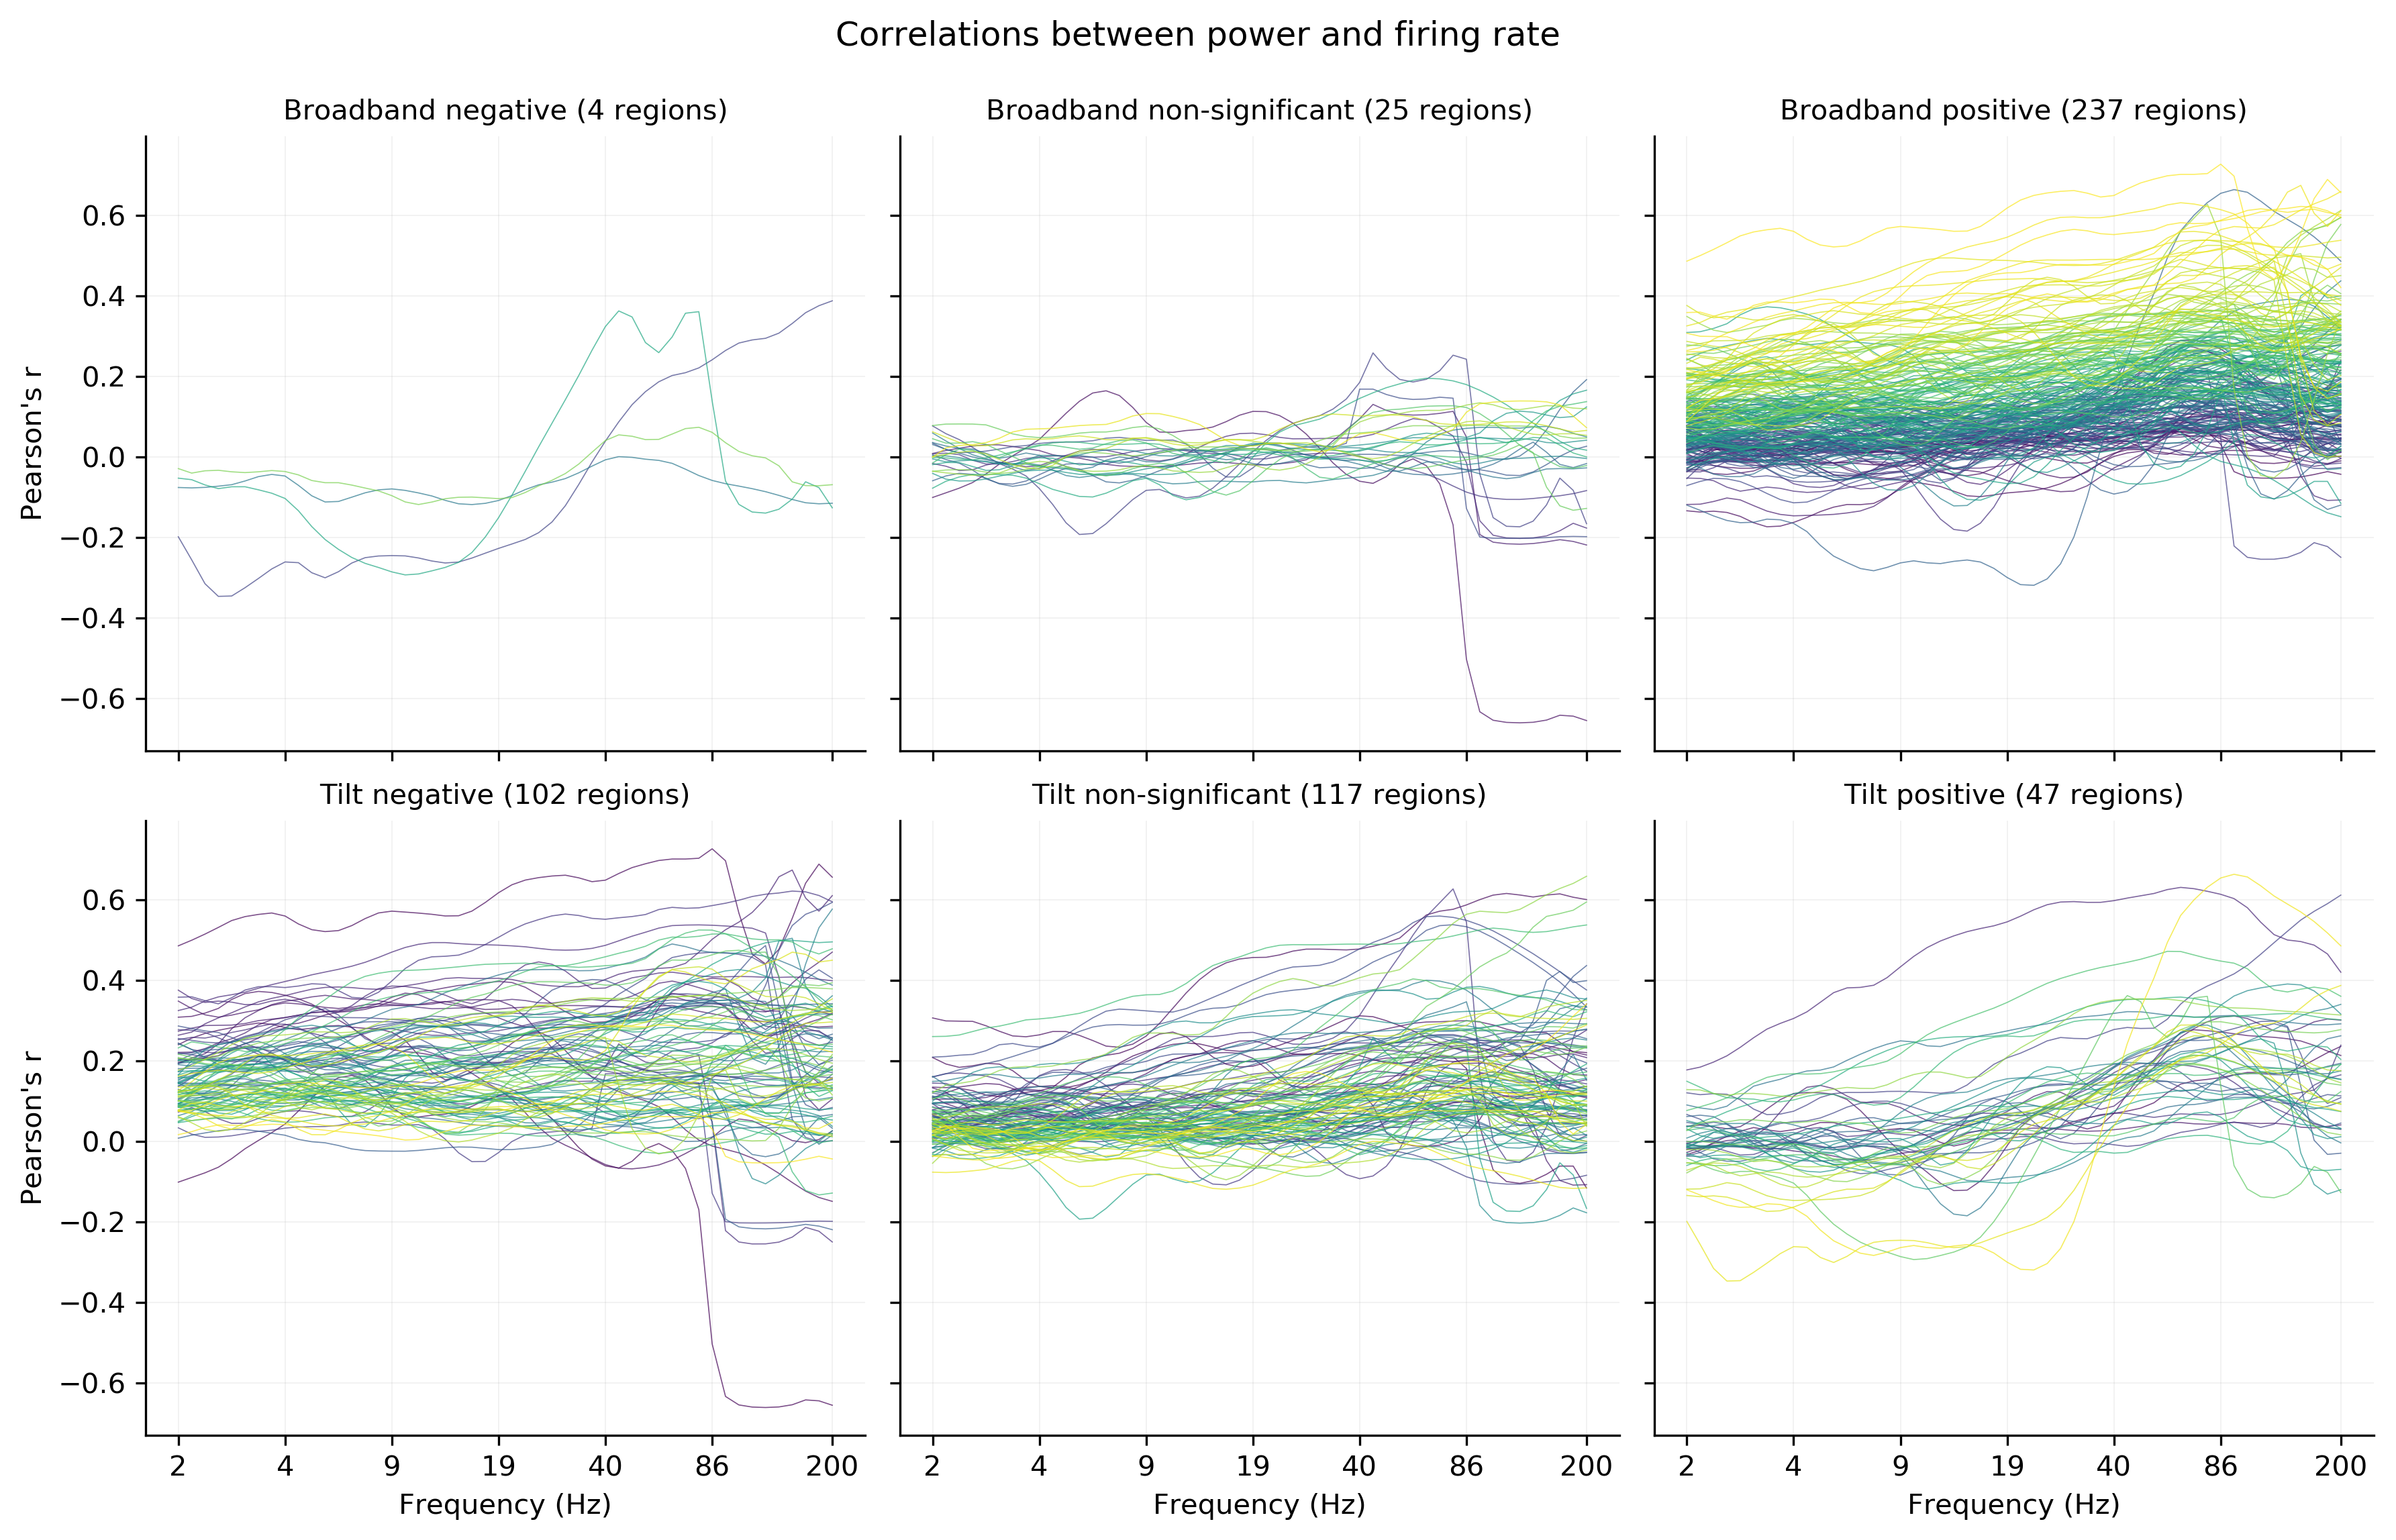

In [549]:
xvals = np.arange(n_freqs)
cmap = 'viridis'
alpha=0.7
linewidth=0.4
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8), dpi=300)
ax = np.ravel(ax)

# Plot data.
keys = (powfr_corr_df.query("(power_measure=='bband_power') & (significance=='neg')")
        .sort_values(by='rval', ascending=True)[['subj_sess', 'roi']].values.tolist())
colors = sns.color_palette(cmap, len(keys))
rvecs = []
for i in range(len(keys)):
    subj_sess, roi = keys[i]
    rvecs.append(freqfr_corrs[subj_sess][roi])
rvecs = np.array(rvecs)
n_rois = rvecs.shape[0]
n_freqs = rvecs.shape[1]
for i in range(n_rois):
    ax[0].plot(xvals, 
               rvecs[i, :], 
               linewidth=linewidth,
               alpha=alpha,
               color=colors[i])
ax[0].set_title(('Broadband negative ({} regions)'.format(n_rois)))

############################

keys = powfr_corr_df.query("(power_measure=='bband_power') & (significance=='ns')").sort_values(by='rval')[['subj_sess', 'roi']].values.tolist()
colors = sns.color_palette(cmap, len(keys))
rvecs = []
for i in range(len(keys)):
    subj_sess, roi = keys[i]
    rvecs.append(freqfr_corrs[subj_sess][roi])
rvecs = np.array(rvecs)
n_rois = rvecs.shape[0]
n_freqs = rvecs.shape[1]
for i in range(n_rois):
    ax[1].plot(xvals, 
               rvecs[i, :], 
               linewidth=linewidth,
               alpha=alpha,
               color=colors[i])
ax[1].set_title(('Broadband non-significant ({} regions)'.format(n_rois)))
    
############################

keys = powfr_corr_df.query("(power_measure=='bband_power') & (significance=='pos')").sort_values(by='rval')[['subj_sess', 'roi']].values.tolist()
colors = sns.color_palette(cmap, len(keys))
rvecs = []
for i in range(len(keys)):
    subj_sess, roi = keys[i]
    rvecs.append(freqfr_corrs[subj_sess][roi])
rvecs = np.array(rvecs)
n_rois = rvecs.shape[0]
n_freqs = rvecs.shape[1]
for i in range(n_rois):
    ax[2].plot(xvals, 
               rvecs[i, :], 
               linewidth=linewidth,
               alpha=alpha,
               color=colors[i])
ax[2].set_title(('Broadband positive ({} regions)'.format(n_rois)))

############################

keys = (powfr_corr_df.query("(power_measure=='tilt') & (significance=='neg')")
        .sort_values(by='rval', ascending=True)[['subj_sess', 'roi']].values.tolist())
colors = sns.color_palette(cmap, len(keys))
rvecs = []
for i in range(len(keys)):
    subj_sess, roi = keys[i]
    rvecs.append(freqfr_corrs[subj_sess][roi])
rvecs = np.array(rvecs)
n_rois = rvecs.shape[0]
n_freqs = rvecs.shape[1]
for i in range(n_rois):
    ax[3].plot(xvals, 
               rvecs[i, :], 
               linewidth=linewidth,
               alpha=alpha,
               color=colors[i])
ax[3].set_title(('Tilt negative ({} regions)'.format(n_rois)))

############################

keys = powfr_corr_df.query("(power_measure=='tilt') & (significance=='ns')").sort_values(by='rval')[['subj_sess', 'roi']].values.tolist()
colors = sns.color_palette(cmap, len(keys))
rvecs = []
for i in range(len(keys)):
    subj_sess, roi = keys[i]
    rvecs.append(freqfr_corrs[subj_sess][roi])
rvecs = np.array(rvecs)
n_rois = rvecs.shape[0]
n_freqs = rvecs.shape[1]
for i in range(n_rois):
    ax[4].plot(xvals, 
               rvecs[i, :], 
               linewidth=linewidth,
               alpha=alpha,
               color=colors[i])
ax[4].set_title(('Tilt non-significant ({} regions)'.format(n_rois)))
    
############################

keys = powfr_corr_df.query("(power_measure=='tilt') & (significance=='pos')").sort_values(by='rval')[['subj_sess', 'roi']].values.tolist()
colors = sns.color_palette(cmap, len(keys))
rvecs = []
for i in range(len(keys)):
    subj_sess, roi = keys[i]
    rvecs.append(freqfr_corrs[subj_sess][roi])
rvecs = np.array(rvecs)
n_rois = rvecs.shape[0]
n_freqs = rvecs.shape[1]
for i in range(n_rois):
    ax[5].plot(xvals, 
               rvecs[i, :], 
               linewidth=linewidth,
               alpha=alpha,
               color=colors[i])
ax[5].set_title(('Tilt positive ({} regions)'.format(n_rois)))

############################
    
# Formatting.
inds = list([int(i) for i in np.linspace(0, 49, 7)])
for i in [3, 4, 5]:
    ax[i].set_xticks(inds)
    ax[i].set_xticklabels([int(round(i, 0)) for i in freqs[inds]], fontsize=10, rotation=0)
    ax[i].set_xlabel('Frequency (Hz)', fontsize=10)

for i in [0, 3]:
    ax[i].set_ylabel("Pearson's r", fontsize=10)

fig.suptitle('Correlations between power and firing rate', y=0.98, fontsize=12)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
f = os.path.join(figure_dir, 'firing_rate_correlated_with_power_at_each_frequency_bband_tilt_groups_expanded.png'.format(n_rois))
fig.savefig(f)

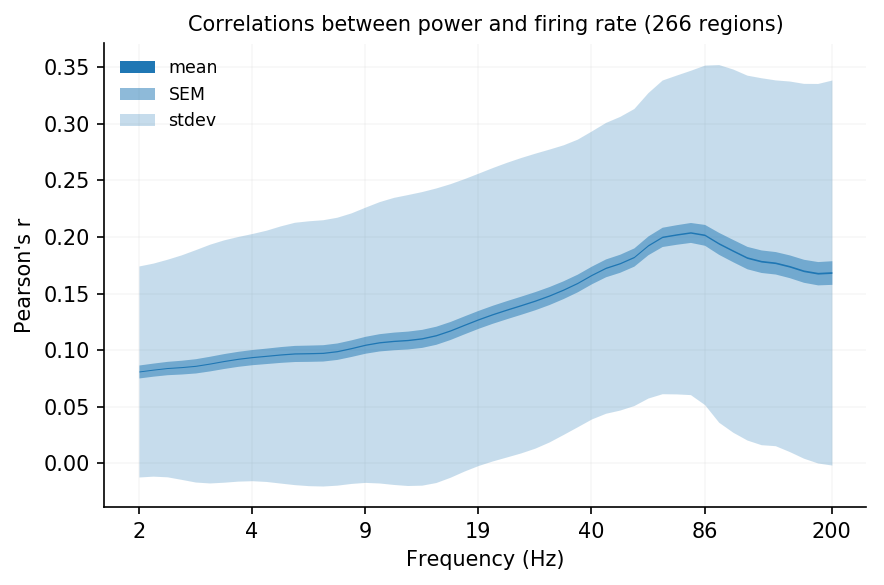

In [534]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
ax = np.ravel(ax)

n_rois = rvecs.shape[0]
n_freqs = rvecs.shape[1]

# ax[0].plot(np.arange(n_freqs), np.mean(rvecs, axis=0), 
#            linewidth=1, color='C0', label='mean')
ax[0].fill_between(np.arange(n_freqs), 
                   np.mean(rvecs, axis=0) - 0.075 * stats.sem(rvecs, axis=0),
                   np.mean(rvecs, axis=0) + 0.075 * stats.sem(rvecs, axis=0),
                   color='C0', alpha=1, linewidth=0, label='mean')
ax[0].fill_between(np.arange(n_freqs), 
                   np.mean(rvecs, axis=0) - stats.sem(rvecs, axis=0),
                   np.mean(rvecs, axis=0) + stats.sem(rvecs, axis=0),
                   color='C0', alpha=0.5, linewidth=0, label='SEM')
ax[0].fill_between(np.arange(n_freqs), 
                   np.mean(rvecs, axis=0) - np.std(rvecs, axis=0),
                   np.mean(rvecs, axis=0) + np.std(rvecs, axis=0),
                   color='C0', alpha=0.25, linewidth=0, label='stdev')

inds = list([int(i) for i in np.linspace(0, 49, 7)])
ax[0].set_xticks(inds)
ax[0].set_xticklabels([int(round(i, 0)) for i in freqs[inds]], fontsize=10, rotation=0)
ax[0].set_xlabel('Frequency (Hz)', fontsize=10)
ax[0].set_ylabel("Pearson's r", fontsize=10)
ax[0].set_title(('Correlations between power and firing rate ({} regions)'.format(n_rois)))
ax[0].legend(loc=2)

fig.tight_layout()
f = os.path.join(figure_dir, 'firing_rate_correlated_with_power_at_each_frequency_{}_regions.png'.format(n_rois))
#fig.savefig(f)

## Pearson correlations between power measures and firing rate, for each region

In [816]:
# Calculate Pearson correlations between firing rate and each
# power measure, for each region.
save_outputs = True
epoch_fr_ = epoch_frz

start = time()
powfr_corrs = OrderedDict()
rvals = OrderedDict()
power_measures = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'allfreq', 'tilt', 'bband_power']
for subj_sess in sessions:
    rois = sorted(keep_chans[subj_sess].keys())
    powfr_corrs[subj_sess] = OrderedDict()
    for roi in rois:
        powfr_corrs[subj_sess][roi] = OrderedDict()
        for power_measure in power_measures:
            results = stats.pearsonr(epoch_fr_[subj_sess][roi], 
                                     epoch_power[subj_sess][roi][power_measure])
            powfr_corrs[subj_sess][roi][power_measure] = results
            rvals.setdefault(power_measure, []).append(results)

if save_outputs:
    fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'powfr_corrs_{}Hz.pkl'.format(epoch_rate))
    with open(fname, 'wb') as f:
        pickle.dump(powfr_corrs, f, pickle.HIGHEST_PROTOCOL)
    print('Saved powfr_corrs as {}'.format(fname))

print('Done in {:.0f} secs'.format(time() - start))   

In [817]:
# Determine significance cutoffs for the correlations between firing rate 
# and each power measure, by performing time-shifted bootstrapping on the 
# firing rate vector. This is done separately for each region.
n_bootstraps = 1000
alpha = 0.05
save_outputs = True

start = time()
powfr_corrs_rand = OrderedDict()
ind_low = int(n_bootstraps*alpha/2)
ind_high = int(n_bootstraps*(1-alpha/2))
for subj_sess in sessions:
    rois = sorted(keep_chans[subj_sess].keys())
    powfr_corrs_rand[subj_sess] = OrderedDict()
    for roi in rois:
        n_epochs = epoch_fr_[subj_sess][roi].shape[0]
        powfr_corrs_rand[subj_sess][roi] = OrderedDict()
        for power_measure in power_measures:
            results = []
            for i in range(n_bootstraps):
                results.append(stats.pearsonr(epoch_fr_[subj_sess][roi][np.roll(np.arange(n_epochs), 1+int(random.random()*n_epochs-1))], 
                                              epoch_power[subj_sess][roi][power_measure])[0])
            results = np.sort(results)
            low_thresh = results[ind_low] # < this value is deemed significant
            high_thresh = results[ind_high] # > this value is deemed significant
            powfr_corrs_rand[subj_sess][roi][power_measure] = OrderedDict([('low', low_thresh),
                                                                           ('high', high_thresh),
                                                                           ('r_vals', results)])
            
if save_outputs:
    fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'powfr_corrs_rand_{}Hz.pkl'.format(epoch_rate))
    with open(fname, 'wb') as f:
        pickle.dump(powfr_corrs_rand, f, pickle.HIGHEST_PROTOCOL)
    print('Saved powfr_corrs_rand as {}'.format(fname))
    
print('Done in {:.0f} secs'.format(time() - start))         

Done in 268 secs


In [857]:
# Collapse the correlation results into a DataFrame and
# record bootstrapped significance for each region.
save_outputs = True

powfr_corr_df = []
col_names = ['power_measure', 'subj_sess', 'roi', 'rval', 'significance']
for power_measure in power_measures:
    for subj_sess in sessions:
        rois = sorted(keep_chans[subj_sess].keys())
        for roi in rois:
            rval = powfr_corrs[subj_sess][roi][power_measure][0]
            low_thresh = powfr_corrs_rand[subj_sess][roi][power_measure]['low']
            high_thresh = powfr_corrs_rand[subj_sess][roi][power_measure]['high']
            if rval < low_thresh:
                significance = 'neg'
            elif rval > high_thresh:
                significance = 'pos'
            else:
                significance = 'ns'
            powfr_corr_df.append([power_measure, subj_sess, roi, rval, significance])
powfr_corr_df = pd.DataFrame(powfr_corr_df, columns=col_names)

if save_outputs:
    fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'powfr_corr_df_{}Hz.xlsx'.format(epoch_rate))
    writer = pd.ExcelWriter(fname)
    powfr_corr_df.to_excel(writer, index=False)
    writer.save()

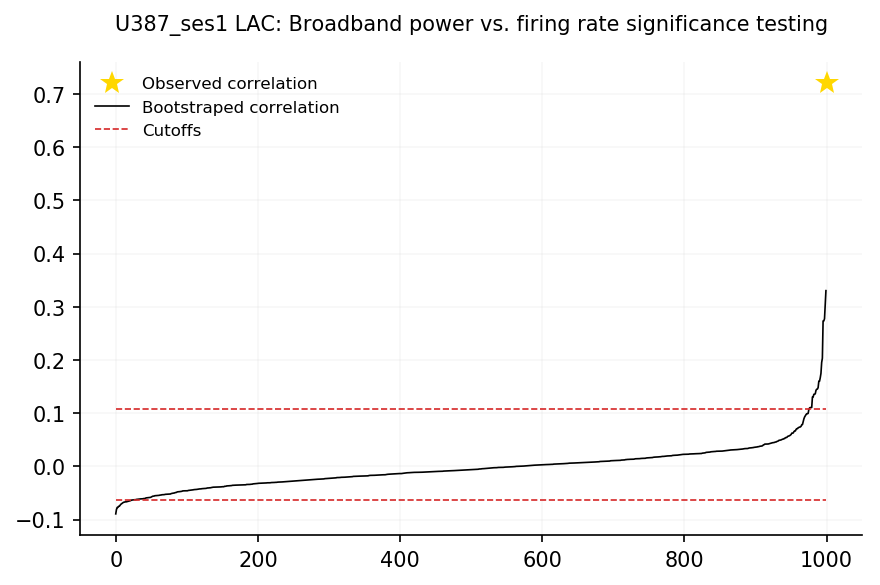

In [1079]:
subj_sess = 'U387_ses1'
roi = 'LAC'
power_measure = 'bband_power'

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax = np.ravel(ax)
n_epochs = len(powfr_corrs_rand[subj_sess][roi][power_measure]['r_vals'])

ax[0].plot(1000, powfr_corrs[subj_sess][roi][power_measure][0], label='Observed correlation',
           marker='*', markerfacecolor='gold', linewidth=0, markersize=12, markeredgewidth=0, markeredgecolor='k')
ax[0].plot(powfr_corrs_rand[subj_sess][roi][power_measure]['r_vals'], color='k', label='Bootstraped correlation')
ax[0].plot(np.repeat(powfr_corrs_rand[subj_sess][roi][power_measure]['low'], n_epochs), color='C1', linestyle='--', label='Cutoffs')
ax[0].plot(np.repeat(powfr_corrs_rand[subj_sess][roi][power_measure]['high'], n_epochs), color='C1', linestyle='--')
ax[0].legend(loc=0, prop={'size': 8})
ax[0].set_title('{} {}: Broadband power vs. firing rate significance testing'.format(subj_sess, roi), y=1.04)
fig.tight_layout()

f = os.path.join(figure_dir, 'bootstrap_testing_example_{}_{}.png'.format(subj_sess, roi))
#fig.savefig(f)

## Percent regions plots

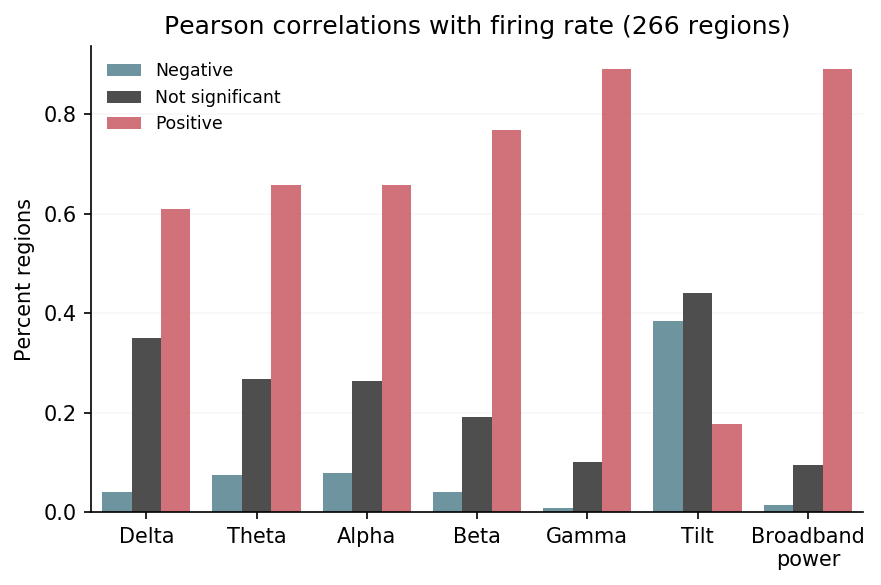

In [139]:
n_rois = powfr_corr_df.groupby('power_measure').count().iat[0, 0]
df = (powfr_corr_df
      .query("(power_measure!='allfreq')")
      .groupby(['power_measure', 'significance'], sort=False)
      .count()[['roi']]
      .apply(lambda x: x/n_rois)
      .reset_index())

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

ax1 = sns.barplot(x='power_measure', y='roi', data=df, ax=ax, 
                 alpha=0.8, hue='significance', hue_order=['neg', 'ns', 'pos'],
                 palette=sns.diverging_palette(220, 10, n=3, center='dark', as_cmap=False))

ax.set_xticklabels(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Tilt', 'Broadband\npower'], fontsize=10)
ax.set_xlabel('')
ax.set_ylabel('Percent regions', fontsize=10)
ax.set_title('Pearson correlations with firing rate ({} regions)'.format(n_rois), fontsize=12)
ax.legend(handles=ax.get_legend().legendHandles, labels=['Negative', 'Not significant', 'Positive'])
fig.tight_layout()

f = os.path.join(figure_dir, 'percent_significant_pearson_corrs_{}_regions.png'.format(n_rois))
#fig.savefig(f)

In [223]:
sig_types = ['neg', 'ns', 'pos']
df_ols2 = []
col_names = ['power_measure', 'significance', 'roi']

pd.concat(((powfr_ols2_df
             .query("(nband_low_significance=='neg')")
             .groupby(['nband_low', 'nband_low_significance'], sort=False)
             .count()[['roi']]
             .apply(lambda x: x/n_rois)
             .reset_index()), 

            (powfr_ols2_df
             .query("(nband_high_significance=='pos')")
             .groupby(['nband_high', 'nband_high_significance'], sort=False)
             .count()[['roi']]
             .apply(lambda x: x/n_rois)
             .reset_index())), axis=0)

d = {}
d['neg'] = (powfr_ols2_df
             .query("(nband_low_significance=='neg')")
             .groupby(['nband_low', 'nband_low_significance'], sort=False)
             .count().roi
             .apply(lambda x: x/n_rois)
             .to_dict())

d['pos'] = (powfr_ols2_df
             .query("(nband_high_significance=='pos')")
             .groupby(['nband_high', 'nband_high_significance'], sort=False)
             .count().roi
             .apply(lambda x: x/n_rois)
             .to_dict())

for band in nbands:
    for sig in sig_types:
        if sig == 'ns':
            df_ols2.append([band, sig, 1 - d['neg'][(band, 'neg')] - d['pos'][(band, 'pos')]])
        else:
            try:
                df_ols2.append([band, sig, d[sig][(band, sig)]])
            except KeyError:
                df_ols2.append([band, sig, 0])

d['bband'] = (powfr_ols2_df
             .groupby(['bband_significance'])
             .count().roi
             .apply(lambda x: x/n_rois)
             .to_dict())

for sig in sig_types:
    try:
        df_ols2.append(['bband_power', sig, d['bband'][sig]])
    except KeyError:
        df_ols2.append(['bband_power', sig, 0])

df_ols2 = pd.DataFrame(df_ols2, columns=col_names)

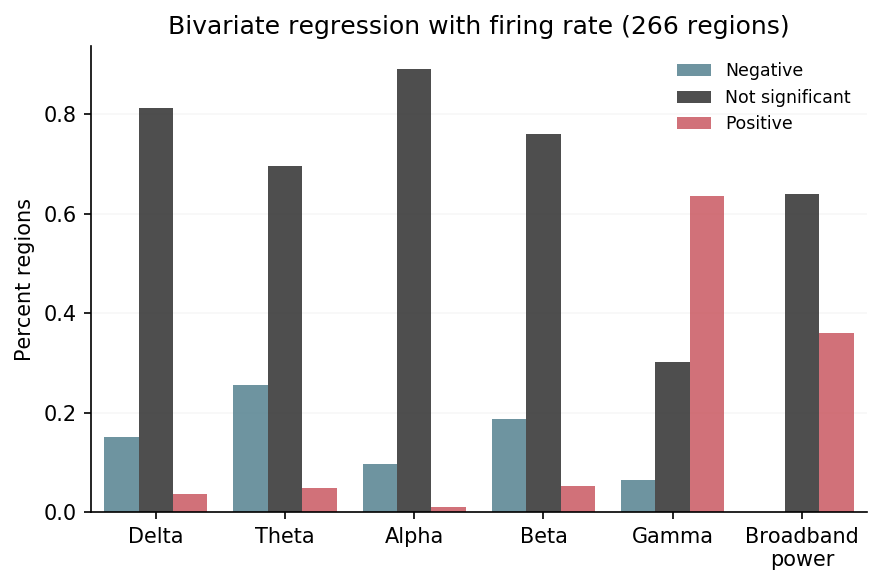

In [232]:
n_rois = powfr_corr_df.groupby('power_measure').count().iat[0, 0]

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

ax1 = sns.barplot(x='power_measure', y='roi', data=df_ols2, ax=ax, 
                 alpha=0.8, hue='significance', hue_order=['neg', 'ns', 'pos'],
                 palette=sns.diverging_palette(220, 10, n=3, center='dark', as_cmap=False))

ax.set_xticklabels(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Broadband\npower'], fontsize=10)
ax.set_xlabel('')
ax.set_ylabel('Percent regions', fontsize=10)
ax.set_title('Bivariate regression with firing rate ({} regions)'.format(n_rois), fontsize=12)
ax.legend(handles=ax.get_legend().legendHandles, labels=['Negative', 'Not significant', 'Positive'])
fig.tight_layout()

f = os.path.join(figure_dir, 'percent_significant_bivariate_model_nband_bband_{}_regions.png'.format(n_rois))
#fig.savefig(f)

In [226]:
sig_types = ['neg', 'ns', 'pos']
df_ols3 = []
col_names = ['power_measure', 'significance', 'roi']

pd.concat(((powfr_ols3_df
             .query("(nband_low_significance=='neg')")
             .groupby(['nband_low', 'nband_low_significance'], sort=False)
             .count()[['roi']]
             .apply(lambda x: x/n_rois)
             .reset_index()), 

            (powfr_ols3_df
             .query("(nband_high_significance=='pos')")
             .groupby(['nband_high', 'nband_high_significance'], sort=False)
             .count()[['roi']]
             .apply(lambda x: x/n_rois)
             .reset_index())), axis=0)

d = {}
d['neg'] = (powfr_ols3_df
             .query("(nband_low_significance=='neg')")
             .groupby(['nband_low', 'nband_low_significance'], sort=False)
             .count().roi
             .apply(lambda x: x/n_rois)
             .to_dict())

d['pos'] = (powfr_ols3_df
             .query("(nband_high_significance=='pos')")
             .groupby(['nband_high', 'nband_high_significance'], sort=False)
             .count().roi
             .apply(lambda x: x/n_rois)
             .to_dict())

for band in nbands:
    for sig in sig_types:
        if sig == 'ns':
            df_ols3.append([band, sig, 1 - d['neg'][(band, 'neg')] - d['pos'][(band, 'pos')]])
        else:
            try:
                df_ols3.append([band, sig, d[sig][(band, sig)]])
            except KeyError:
                df_ols3.append([band, sig, 0])

d['tilt'] = (powfr_ols3_df
             .groupby(['tilt_significance'])
             .count().roi
             .apply(lambda x: x/n_rois)
             .to_dict())

for sig in sig_types:
    try:
        df_ols3.append(['tilt', sig, d['tilt'][sig]])
    except KeyError:
        df_ols3.append(['tilt', sig, 0])
        
d['bband'] = (powfr_ols3_df
             .groupby(['bband_significance'])
             .count().roi
             .apply(lambda x: x/n_rois)
             .to_dict())

for sig in sig_types:
    try:
        df_ols3.append(['bband_power', sig, d['bband'][sig]])
    except KeyError:
        df_ols3.append(['bband_power', sig, 0])

df_ols3 = pd.DataFrame(df_ols3, columns=col_names)

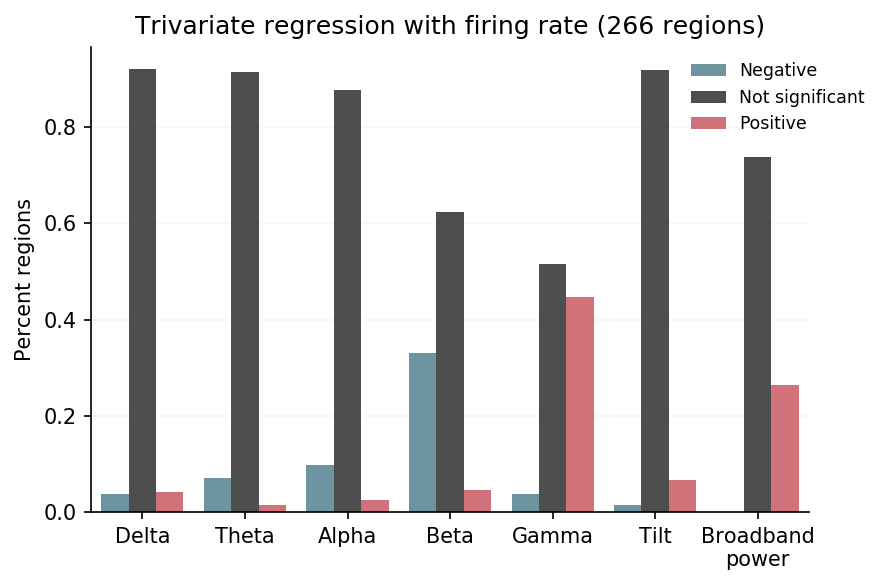

In [238]:
n_rois = powfr_corr_df.groupby('power_measure').count().iat[0, 0]

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

ax1 = sns.barplot(x='power_measure', y='roi', data=df_ols3, ax=ax, 
                 alpha=0.8, hue='significance', hue_order=['neg', 'ns', 'pos'],
                 palette=sns.diverging_palette(220, 10, n=3, center='dark', as_cmap=False))

ax.set_xticklabels(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Tilt', 'Broadband\npower'], fontsize=10)
ax.set_xlabel('')
ax.set_ylabel('Percent regions', fontsize=10)
ax.set_title('Trivariate regression with firing rate ({} regions)'.format(n_rois), fontsize=12)
ax.legend(handles=ax.get_legend().legendHandles, labels=['Negative', 'Not significant', 'Positive'], loc=1, bbox_to_anchor=(1.1, 1))
fig.tight_layout()

f = os.path.join(figure_dir, 'percent_significant_trivariate_model_nband_bband_tilt_{}_regions.png'.format(n_rois))
#fig.savefig(f)

In [ ]:
# U387_ses1 LAC is the top +corr for broadband power
# U379_ses1 RpSMA is the top +corr for tilt
# U367_env2 RPH is the top -corr for tilt
# U387_ses1 LAC is the top +corr for theta
# U394_ses1 ROF is the top -corr for theta
# U387_ses1 LAC is the top +corr for gamma
# U394_ses1 ROF is the top -corr for gamma

## Regression models of power measures predicting firing rate, for each region

In [1076]:
# For each region, run bivariate (nband + bband) 
# and trivariate (nband + tilt + bband) regression models 
# predicting firing rate across epochs.
save_outputs = True
epoch_fr_ = epoch_frz

start = time()
powfr_betas2 = OrderedDict()
powfr_betas3 = OrderedDict()
nbands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
for subj_sess in sessions:
    rois = sorted(keep_chans[subj_sess].keys())
    powfr_betas2[subj_sess] = OrderedDict()
    powfr_betas3[subj_sess] = OrderedDict()
    for roi in rois:
        powfr_betas2[subj_sess][roi] = OrderedDict()
        powfr_betas3[subj_sess][roi] = OrderedDict()
        y = epoch_fr_[subj_sess][roi]
        for nband in nbands:
            dat = np.vstack((epoch_power[subj_sess][roi][nband],
                             epoch_power[subj_sess][roi]['bband_power'])).T
            X2 = sm.add_constant(dat)
            dat = np.vstack((epoch_power[subj_sess][roi][nband],
                             epoch_power[subj_sess][roi]['bband_power'],
                             epoch_power[subj_sess][roi]['tilt'])).T
            X3 = sm.add_constant(dat)
            results2 = sm.OLS(y, X2).fit()
            results3 = sm.OLS(y, X3).fit()
            _, nband_beta2, bband_beta2 = results2.params
            _, nband_beta3, bband_beta3, tilt_beta3 = results3.params
            powfr_betas2[subj_sess][roi][nband] = {'nband': nband_beta2, 
                                                   'bband': bband_beta2,
                                                   'results': results2}
            powfr_betas3[subj_sess][roi][nband] = {'nband': nband_beta3, 
                                                   'bband': bband_beta3,
                                                   'tilt': tilt_beta3,
                                                   'results': results3}

if save_outputs:
    fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'powfr_betas2_{}Hz.pkl'.format(epoch_rate))
    with open(fname, 'wb') as f:
        pickle.dump(powfr_betas2, f, pickle.HIGHEST_PROTOCOL)
    print('Saved powfr_betas2 as {}'.format(fname))
    
    fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'powfr_betas3_{}Hz.pkl'.format(epoch_rate))
    with open(fname, 'wb') as f:
        pickle.dump(powfr_betas3, f, pickle.HIGHEST_PROTOCOL)
    print('Saved powfr_betas3 as {}'.format(fname))
    
print('Done in {:.0f} secs'.format(time() - start))   

Saved powfr_betas2 as /data3/scratch/dscho/frLfp/data/virtual_lfp/epoch/powfr_betas2_2Hz.pkl
Saved powfr_betas3 as /data3/scratch/dscho/frLfp/data/virtual_lfp/epoch/powfr_betas3_2Hz.pkl
Done in 7 secs


In [1208]:
# Determine significance cutoffs for the regression models between
# firing rate and power, by performing time-shifted bootstrapping
# on the firing rate vector. This is done separately for each region.
n_bootstraps = 1000
alpha = 0.05
save_outputs = True

start = time()
powfr_betas2_rand = OrderedDict()
powfr_betas3_rand = OrderedDict()
ind_low = int(n_bootstraps*alpha/2)
ind_high = int(n_bootstraps*(1-alpha/2))
for subj_sess in sessions:
    rois = sorted(keep_chans[subj_sess].keys())
    powfr_betas2_rand[subj_sess] = OrderedDict()
    powfr_betas3_rand[subj_sess] = OrderedDict()
    for roi in rois:
        n_epochs = epoch_fr_[subj_sess][roi].shape[0]
        powfr_betas2_rand[subj_sess][roi] = OrderedDict()
        powfr_betas3_rand[subj_sess][roi] = OrderedDict()
        
        # Randomly shift the firing rate vector
        y = []
        for i in range(n_bootstraps):
            y.append(epoch_fr_[subj_sess][roi][np.roll(np.arange(n_epochs), 1+int(random.random()*n_epochs-1))])
            
        for nband in nbands:
            # Create the predictor matrices for each regression model.
            dat = np.vstack((epoch_power[subj_sess][roi][nband],
                             epoch_power[subj_sess][roi]['bband_power'])).T
            X2 = sm.add_constant(dat)
            dat = np.vstack((epoch_power[subj_sess][roi][nband],
                             epoch_power[subj_sess][roi]['bband_power'],
                             epoch_power[subj_sess][roi]['tilt'])).T
            X3 = sm.add_constant(dat)
            
            nband_beta2s = []
            bband_beta2s = []
            nband_beta3s = []
            bband_beta3s = []
            tilt_beta3s = []
            for i in range(n_bootstraps):
                # Run the regression model for firing_rate ~ nband + bband
                _, nband_beta2, bband_beta2 = sm.OLS(y[i], X2).fit().params
                nband_beta2s.append(nband_beta2)
                bband_beta2s.append(bband_beta2)
                
                # Run the regression model for firing_rate ~ nband + bband + tilt
                _, nband_beta3, bband_beta3, tilt_beta3 = sm.OLS(y[i], X3).fit().params
                nband_beta3s.append(nband_beta3)
                bband_beta3s.append(bband_beta3)
                tilt_beta3s.append(tilt_beta3)
                
            # Sort bootstrapped beta weights and draw cutoffs
            # based on the selected alpha.
            nband_beta2s = np.sort(nband_beta2s)
            bband_beta2s = np.sort(bband_beta2s)
            nband_beta3s = np.sort(nband_beta3s)
            bband_beta3s = np.sort(bband_beta3s)
            tilt_beta3s = np.sort(tilt_beta3s)
            
            output2 = OrderedDict([('nband_beta_low', nband_beta2s[ind_low]),
                                   ('nband_beta_high', nband_beta2s[ind_high]),
                                   ('nband_betas', nband_beta2s),
                                   ('bband_beta_low', bband_beta2s[ind_low]),
                                   ('bband_beta_high', bband_beta2s[ind_high]),
                                   ('bband_betas', bband_beta2s)])
            powfr_betas2_rand[subj_sess][roi][nband] = output2
            
            output3 = OrderedDict([('nband_beta_low', nband_beta3s[ind_low]),
                                   ('nband_beta_high', nband_beta3s[ind_high]),
                                   ('nband_betas', nband_beta3s),
                                   ('bband_beta_low', bband_beta3s[ind_low]),
                                   ('bband_beta_high', bband_beta3s[ind_high]),
                                   ('bband_betas', bband_beta3s),
                                   ('tilt_beta_low', tilt_beta3s[ind_low]),
                                   ('tilt_beta_high', tilt_beta3s[ind_high]),
                                   ('tilt_betas', tilt_beta3s)])
            powfr_betas3_rand[subj_sess][roi][nband] = output3
                        
if save_outputs:
    fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'powfr_betas2_rand_{}Hz.pkl'.format(epoch_rate))
    with open(fname, 'wb') as f:
        pickle.dump(powfr_betas2_rand, f, pickle.HIGHEST_PROTOCOL)
    print('Saved powfr_betas2_rand as {}'.format(fname))
    
    fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'powfr_betas3_rand_{}Hz.pkl'.format(epoch_rate))
    with open(fname, 'wb') as f:
        pickle.dump(powfr_betas3_rand, f, pickle.HIGHEST_PROTOCOL)
    print('Saved powfr_betas3_rand as {}'.format(fname))
    
print('Done in {:.0f} secs'.format(time() - start))         

Saved powfr_betas2_rand as /data3/scratch/dscho/frLfp/data/virtual_lfp/epoch/powfr_betas2_rand_2Hz.pkl
Saved powfr_betas3_rand as /data3/scratch/dscho/frLfp/data/virtual_lfp/epoch/powfr_betas3_rand_2Hz.pkl
Done in 1446 secs


In [150]:
# firing_rate ~ nband + bband
# Collapse the regression results into a DataFrame and
# record bootstrapped significance for each region.
save_outputs = True

powfr_ols2_df = []
col_names = ['subj_sess', 'roi', 
             'bband_beta', 'bband_significance',
             'nband_low', 'nband_low_beta', 'nband_low_significance', 
             'nband_high', 'nband_high_beta', 'nband_high_significance']

for subj_sess in sessions:
    rois = sorted(keep_chans[subj_sess].keys())
    for roi in rois:
        output_row = [subj_sess, roi]
        
        # Determine if the region has a broadband effect.
        bband_betas = np.array([powfr_betas2[subj_sess][roi][nband]['bband'] for nband in nbands])
        bband_low_thresholds = np.array([powfr_betas2_rand[subj_sess][roi][nband]['bband_beta_low'] for nband in nbands])
        bband_high_thresholds = np.array([powfr_betas2_rand[subj_sess][roi][nband]['bband_beta_high'] for nband in nbands])
        if np.all(bband_betas < 0) and np.all(bband_betas < bband_low_thresholds):
            bband_sig = 'neg'
        elif np.all(bband_betas > 0) and np.all(bband_betas > bband_high_thresholds):
            bband_sig = 'pos'
        else:
            bband_sig = 'ns'
        output_row += [np.mean(bband_betas), bband_sig]
        
        # Determine if the region has a narrowband effect.
        # A negative effect is assigned to the band with the lowest beta weight,
        # if the beta weight is < 0 and < the low bootstrap cutoff.
        # A positive effect is assigned to the band with the highest beta weight,
        # if the beta weight is > 0 and > the high bootstrap cutoff.
        nband_betas = []
        nband_sigs = []
        for nband in nbands:
            nband_beta = powfr_betas2[subj_sess][roi][nband]['nband']
            nband_beta_low = powfr_betas2_rand[subj_sess][roi][nband]['nband_beta_low']
            nband_beta_high = powfr_betas2_rand[subj_sess][roi][nband]['nband_beta_high']
            nband_betas.append(nband_beta)
            if nband_beta < min(0, nband_beta_low):
                nband_sigs.append('neg')
            elif nband_beta > max(0, nband_beta_high):
                nband_sigs.append('pos')
            else:
                nband_sigs.append('ns')
          
        nband_betas = np.array(nband_betas)
        xsort = np.argsort(nband_betas)
        output_row += [nbands[xsort[0]], nband_betas[xsort[0]], nband_sigs[xsort[0]], 
                       nbands[xsort[-1]], nband_betas[xsort[-1]], nband_sigs[xsort[-1]]]
        
        powfr_ols2_df.append(output_row)

powfr_ols2_df = pd.DataFrame(powfr_ols2_df, columns=col_names)

if save_outputs:
    fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'powfr_ols2_df_{}Hz.xlsx'.format(epoch_rate))
    writer = pd.ExcelWriter(fname)
    powfr_ols2_df.to_excel(writer, index=False)
    writer.save()

In [151]:
# firing_rate ~ nband + bband + tilt
# Collapse the regression results into a DataFrame and
# record bootstrapped significance for each region.
save_outputs = True

powfr_ols3_df = []
col_names = ['subj_sess', 'roi', 
             'bband_beta', 'bband_significance',
             'tilt_beta', 'tilt_significance',
             'nband_low', 'nband_low_beta', 'nband_low_significance', 
             'nband_high', 'nband_high_beta', 'nband_high_significance']

for subj_sess in sessions:
    rois = sorted(keep_chans[subj_sess].keys())
    for roi in rois:
        output_row = [subj_sess, roi]
        
        # Determine if the region has a broadband effect.
        bband_betas = np.array([powfr_betas3[subj_sess][roi][nband]['bband'] for nband in nbands])
        bband_low_thresholds = np.array([powfr_betas3_rand[subj_sess][roi][nband]['bband_beta_low'] for nband in nbands])
        bband_high_thresholds = np.array([powfr_betas3_rand[subj_sess][roi][nband]['bband_beta_high'] for nband in nbands])
        if np.all(bband_betas < 0) and np.all(bband_betas < bband_low_thresholds):
            bband_sig = 'neg'
        elif np.all(bband_betas > 0) and np.all(bband_betas > bband_high_thresholds):
            bband_sig = 'pos'
        else:
            bband_sig = 'ns'
        output_row += [np.mean(bband_betas), bband_sig]
        
        # Determine if the region has a tilt effect.
        tilt_betas = np.array([powfr_betas3[subj_sess][roi][nband]['tilt'] for nband in nbands])
        tilt_low_thresholds = np.array([powfr_betas3_rand[subj_sess][roi][nband]['tilt_beta_low'] for nband in nbands])
        tilt_high_thresholds = np.array([powfr_betas3_rand[subj_sess][roi][nband]['tilt_beta_high'] for nband in nbands])
        if np.all(tilt_betas < 0) and np.all(tilt_betas < tilt_low_thresholds):
            tilt_sig = 'neg'
        elif np.all(tilt_betas > 0) and np.all(tilt_betas > tilt_high_thresholds):
            tilt_sig = 'pos'
        else:
            tilt_sig = 'ns'
        output_row += [np.mean(tilt_betas), tilt_sig]
        
        # Determine if the region has a narrowband effect.
        # A negative effect is assigned to the band with the lowest beta weight,
        # if the beta weight is < 0 and < the low bootstrap cutoff.
        # A positive effect is assigned to the band with the highest beta weight,
        # if the beta weight is > 0 and > the high bootstrap cutoff.
        nband_betas = []
        nband_sigs = []
        for nband in nbands:
            nband_beta = powfr_betas3[subj_sess][roi][nband]['nband']
            nband_beta_low = powfr_betas3_rand[subj_sess][roi][nband]['nband_beta_low']
            nband_beta_high = powfr_betas3_rand[subj_sess][roi][nband]['nband_beta_high']
            nband_betas.append(nband_beta)
            if nband_beta < min(0, nband_beta_low):
                nband_sigs.append('neg')
            elif nband_beta > max(0, nband_beta_high):
                nband_sigs.append('pos')
            else:
                nband_sigs.append('ns')
          
        nband_betas = np.array(nband_betas)
        xsort = np.argsort(nband_betas)
        output_row += [nbands[xsort[0]], nband_betas[xsort[0]], nband_sigs[xsort[0]], 
                       nbands[xsort[-1]], nband_betas[xsort[-1]], nband_sigs[xsort[-1]]]
        
        powfr_ols3_df.append(output_row)

powfr_ols3_df = pd.DataFrame(powfr_ols3_df, columns=col_names)

if save_outputs:
    fname = os.path.join(data_dir, 'virtual_lfp', 'epoch', 'powfr_ols3_df_{}Hz.xlsx'.format(epoch_rate))
    writer = pd.ExcelWriter(fname)
    powfr_ols3_df.to_excel(writer, index=False)
    writer.save()

In [228]:
# # 'bband_significance', 'tilt_significance', 'nband_low_significance', 'nband_high_significance'
    
# print(powfr_ols2_df.groupby('bband_significance').count()[['roi']].apply(lambda x: x/len(powfr_ols2_df)))

# print(powfr_ols2_df.groupby(['nband_low']).count()[['roi']].apply(lambda x: x/len(powfr_ols2_df)))

# print(powfr_ols2_df.groupby(['nband_low_significance']).count()[['roi']].apply(lambda x: x/len(powfr_ols2_df)))

# print(powfr_ols2_df.groupby(['nband_low', 'nband_low_significance']).count()[['roi']].apply(lambda x: x/len(powfr_ols2_df)))

# print(powfr_ols2_df.groupby(['nband_high']).count()[['roi']].apply(lambda x: x/len(powfr_ols2_df)))

# print(powfr_ols2_df.groupby(['nband_high_significance']).count()[['roi']].apply(lambda x: x/len(powfr_ols2_df)))

# print(powfr_ols2_df.groupby(['nband_high', 'nband_high_significance']).count()[['roi']].apply(lambda x: x/len(powfr_ols2_df)))

# print(powfr_ols2_df.query("(nband_low_significance=='neg') & (nband_high_significance=='pos')").groupby(['nband_low', 'nband_high']).roi.count())

In [1258]:
# How often do we see 2 narrowbands in the same region that are   
# correlated negatively and positively with firing rate, respectively?
# 1) when the freq of the positive band > the freq of the negative band
# 2) when the freq of the positive band < the freq of the negative band
(25+40+1+2+35+1+62) / len(powfr_ols2_df), (2+4+1+5+5+6) / len(powfr_ols2_df)

(0.6240601503759399, 0.08646616541353383)

In [230]:
# # 'bband_significance', 'tilt_significance', 'nband_low_significance', 'nband_high_significance'
    
# print(powfr_ols3_df.groupby('bband_significance').count()[['roi']].apply(lambda x: x/len(powfr_ols2_df)))

# print(powfr_ols3_df.groupby('tilt_significance').count()[['roi']].apply(lambda x: x/len(powfr_ols2_df)))

# print(powfr_ols3_df.groupby(['nband_low']).count()[['roi']].apply(lambda x: x/len(powfr_ols2_df)))

# print(powfr_ols3_df.groupby(['nband_low_significance']).count()[['roi']].apply(lambda x: x/len(powfr_ols2_df)))

# print(powfr_ols3_df.groupby(['nband_low', 'nband_low_significance']).count()[['roi']].apply(lambda x: x/len(powfr_ols2_df)))

# print(powfr_ols3_df.groupby(['nband_high']).count()[['roi']].apply(lambda x: x/len(powfr_ols2_df)))

# print(powfr_ols3_df.groupby(['nband_high_significance']).count()[['roi']].apply(lambda x: x/len(powfr_ols2_df)))

# print(powfr_ols3_df.groupby(['nband_high', 'nband_high_significance']).count()[['roi']].apply(lambda x: x/len(powfr_ols2_df)))

# print(powfr_ols3_df.query("(nband_low_significance=='neg') & (nband_high_significance=='pos')").groupby(['nband_low', 'nband_high']).roi.count())

In [1259]:
# How often do we see 2 narrowbands in the same region that are   
# correlated negatively and positively with firing rate, respectively?
# 1) when the freq of the positive band > the freq of the negative band
# 2) when the freq of the positive band < the freq of the negative band
(21+74+2+1+1+1+10) / len(powfr_ols3_df), (2+2+8+3) / len(powfr_ols3_df)

(0.41353383458646614, 0.05639097744360902)

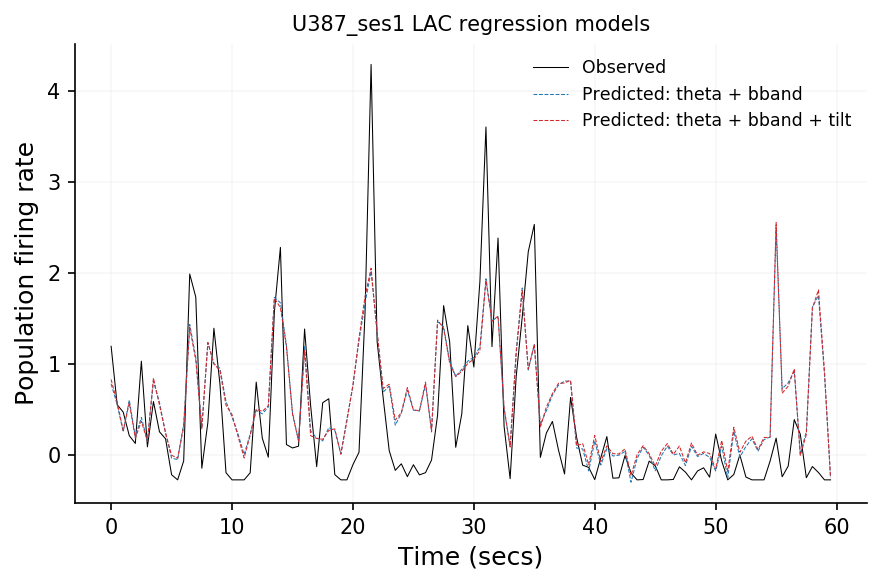

In [1250]:
subj_sess = 'U387_ses1'
roi = 'LAC'
nband = 'theta'

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax = np.ravel(ax)

start = 0
duration = 120
ax[0].plot(np.arange(len(epoch_fr[subj_sess][roi][start:start+duration])), 
           epoch_fr[subj_sess][roi][start:start+duration],
           color='k', linewidth=0.5, label='Observed')
ax[0].plot(np.arange(len(epoch_fr[subj_sess][roi][start:start+duration])), 
           powfr_betas2[subj_sess][roi][nband]['results'].predict()[start:start+duration], 
           color='C0', linewidth=0.5, linestyle='--', label='Predicted: {} + bband'.format(nband))
ax[0].plot(np.arange(len(epoch_fr[subj_sess][roi][start:start+duration])), 
           powfr_betas3[subj_sess][roi][nband]['results'].predict()[start:start+duration], 
           color='C1', linewidth=0.5, linestyle='--', label='Predicted: {} + bband + tilt'.format(nband))

ax[0].set_xticks(np.linspace(0, duration, 7))
ax[0].set_xticklabels([int(i) for i in np.linspace(start, start+duration, 7) / epoch_rate])
ax[0].set_xlabel('Time (secs)', fontsize=12)
ax[0].set_ylabel('Population firing rate', fontsize=12)
ax[0].legend()
ax[0].set_title('{} {} regression models'.format(subj_sess, roi))
fig.tight_layout()

## Power measure correlation matrix, across regions

In [962]:
# Construct a correlation matrix for power values,
# taken as the average across regions.
roi_power_corrms = []
for subj_sess in sessions:
    rois = sorted(keep_chans[subj_sess].keys())
    for roi in rois:
        power_vals = []
        for power_measure in power_measures:
            # skip past allfreq; it correlates ~perfectly with bband_power
            if power_measure == 'allfreq':
                continue
            power_vals.append(epoch_power[subj_sess][roi][power_measure])
        roi_power_corrms.append(np.corrcoef(np.array(power_vals)))

roi_power_corrms = np.array(roi_power_corrms)
mean_power_corrms = np.mean(roi_power_corrms, axis=0)

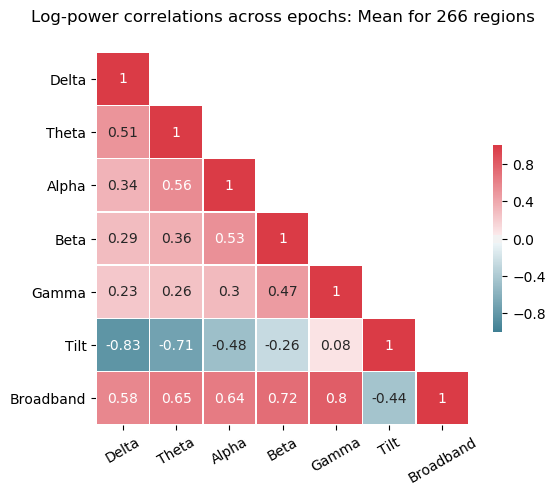

In [1262]:
# Plot the correlation matrix for band power measures over time.

# Generate a mask for the upper triangle
mask = np.zeros_like(mean_power_corrms, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
ax = np.ravel(ax)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(mean_power_corrms, annot=True, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

axis_labels = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Tilt', 'Broadband']
ax[0].set_xticks(0.5 + np.arange(len(axis_labels)))
ax[0].set_xticklabels(axis_labels, fontsize=10, rotation=30)
ax[0].set_yticks(0.5 + np.arange(len(axis_labels)))
ax[0].set_yticklabels(axis_labels, fontsize=10, rotation=0)
ax[0].set_title('Log-power correlations across epochs: Mean for {} regions'.format(roi_power_corrms.shape[0]), fontsize=12, y=1.06)
fig.tight_layout()

f = os.path.join(figure_dir, 'band_power_corrmats_{}_regions.png'.format(roi_power_corrms.shape[0]))
#fig.savefig(f)